# Sistema de Recomendação de Compras

## Preparação do ambiente

### Instalando as bibliotecas

In [2279]:
# !pip install --user -r requirements.txt

### Importando os pacotes

In [2280]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import scipy.stats as st
import sweetviz as sv
import seaborn as sns
import statistics  as sts
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from tpot import TPOTClassifier
from yellowbrick.model_selection import FeatureImportances
import chardet
from datetime import datetime
from datetime import date
from calendar import monthrange
import os
import random

## Funções

In [2281]:
def EliminarDuplicadas (dataframe): 
    return dataframe.drop_duplicates()

In [2282]:
def EliminarOutliers (coluna):
    limitesuperior = coluna.mean() + 3*coluna.std()
    limiteinferior = coluna.mean() - 3*coluna.std()
    return coluna.apply(lambda x: limitesuperior if x>= limitesuperior else limiteinferior if x<= limiteinferior else x)

In [2283]:
def Corresp(dataset1, dataset2, coluna):
    dtTeste1 = dataset1[coluna].to_frame()
    dtTeste1['count1'] = 1
    dtTeste1

    dtTeste2 = dataset2[coluna].to_frame()
    dtTeste2['count2'] = 1
    dtTeste2

    dtTesteM1 = dtTeste1.merge(dtTeste2, how='outer')
    dtTesteM1

    print('Valores de ' + coluna + ' não inclusos no primeiro dataset: ' + str(len(dtTesteM1[dtTesteM1['count2'].isna()])))

    dtTesteM2 = dtTeste2.merge(dtTeste1, how='outer')
    dtTesteM2

    print('Valores de ' + coluna + ' não inclusos no segundo dataset: ' + str(len(dtTesteM2[dtTesteM2['count1'].isna()])))

## Leitura de dados

In [2284]:
dtOrderItems = pd.read_csv('Dados\DNC_order_items_dataset.csv').drop(columns='Unnamed: 0')
dtOrderReviews = pd.read_csv('Dados\DNC_order_reviews_dataset.csv').drop(columns='Unnamed: 0')
dtOrders = pd.read_csv('Dados\DNC_orders_dataset.csv').drop(columns='Unnamed: 0')
dtProducts = pd.read_csv('Dados\DNC_products_dataset.csv').drop(columns='Unnamed: 0')

In [2285]:
dtOrderItems

,order_id,order_item_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90
...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,299.99
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,350.00
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,99.90
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,55.99


In [2286]:
dtOrderReviews

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4


In [2287]:
dtOrders

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered


In [2288]:
dtProducts

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,700.0,31.0,13.0,20.0


## Exploração

### Order Items

DNC_order_items_dataset
<br />	order_id - Id do pedido de compra;
<br />	order_item_id – Número de produtos em uma mesma compra;
<br />	product_id – Id do produto;
<br />	price - preço;

In [2289]:
dtOrderItems

,order_id,order_item_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90
...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,299.99
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,350.00
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,99.90
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,55.99


In [2290]:
dtOrderItems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       112650 non-null  object 
 1   order_item_id  112650 non-null  int64  
 2   product_id     112650 non-null  object 
 3   price          112650 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.4+ MB


In [2291]:
dtOrderItems.describe()

,order_item_id,price
count,112650.000000,112650.000000
mean,1.197834,120.653739
std,0.705124,183.633928
min,1.000000,0.850000
25%,1.000000,39.900000
50%,1.000000,74.990000
75%,1.000000,134.900000
max,21.000000,6735.000000


In [2292]:
dtOrderItems.describe(include = 'object')

,order_id,product_id
count,112650,112650
unique,98666,32951
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af
freq,21,527


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



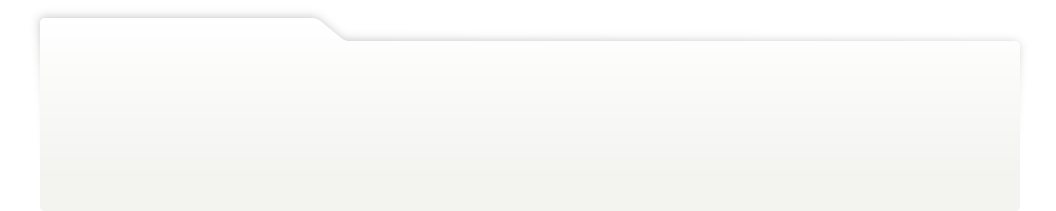
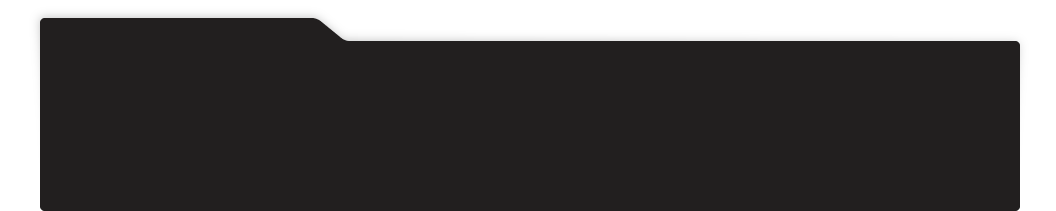
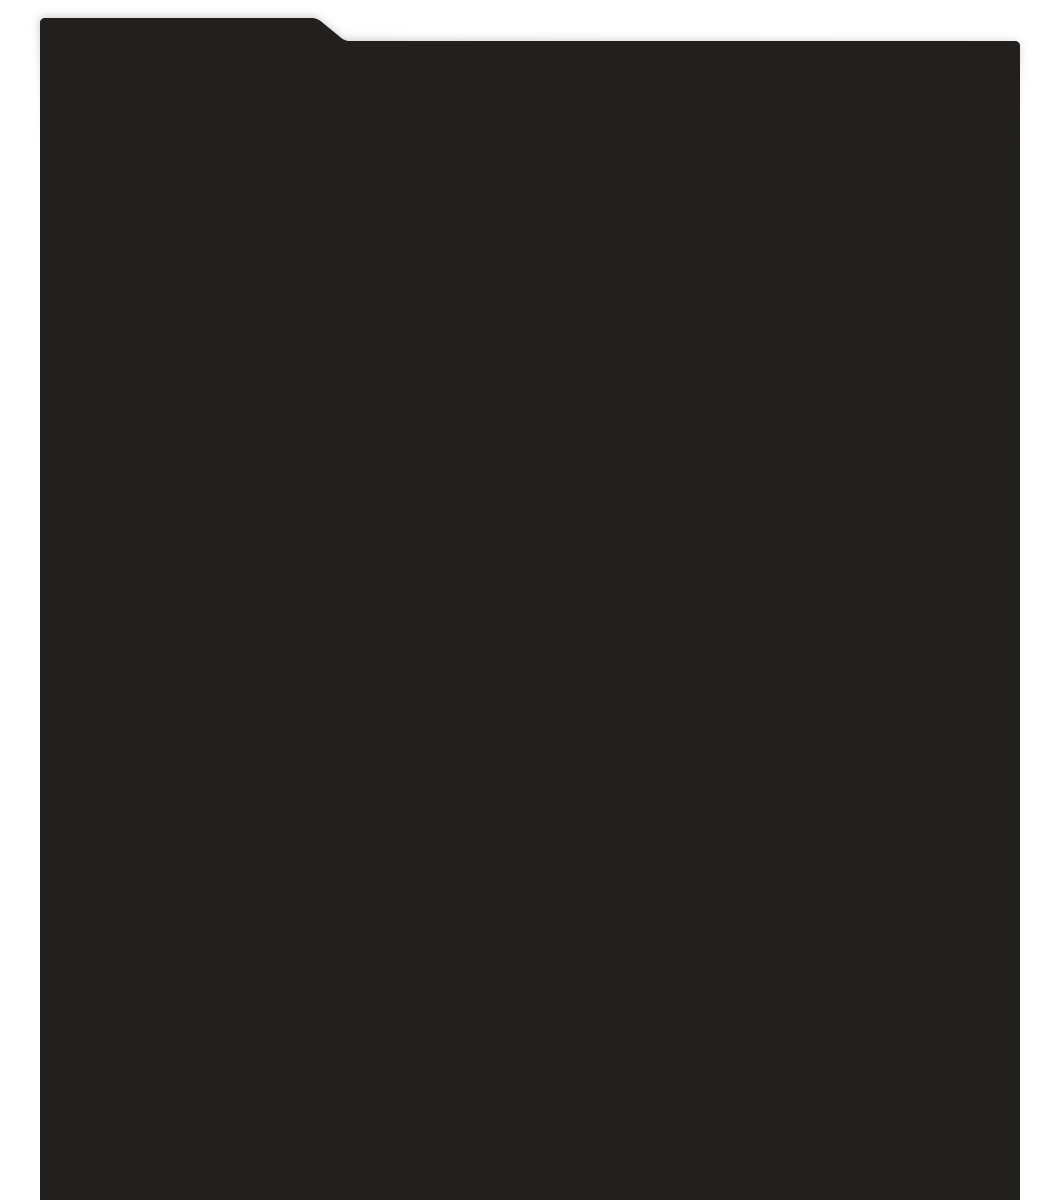
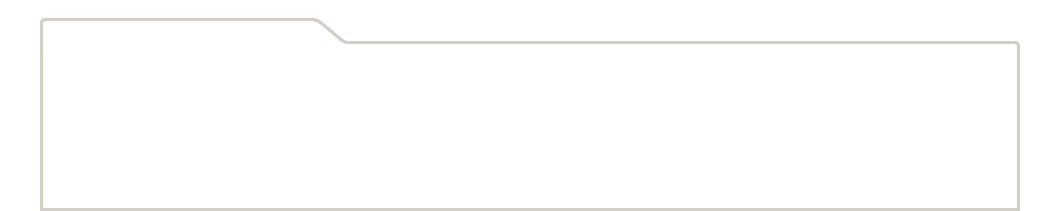
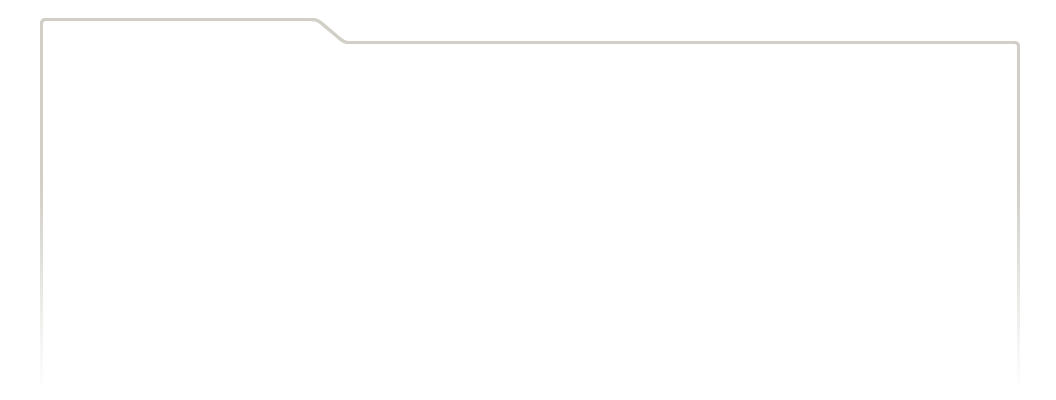
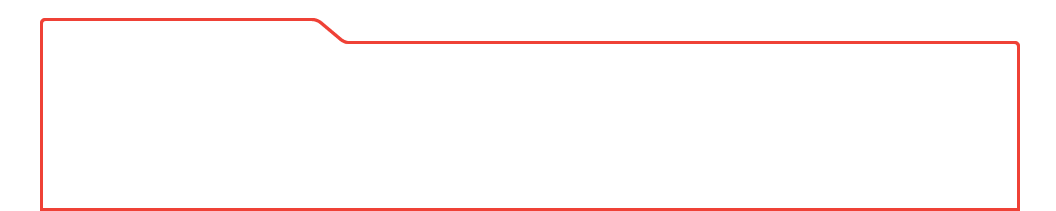
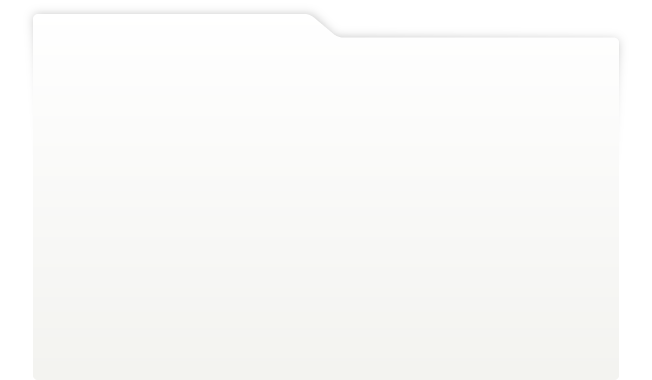
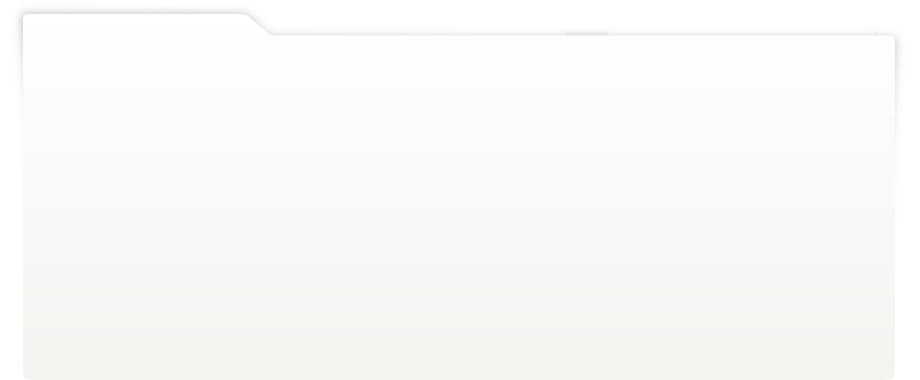
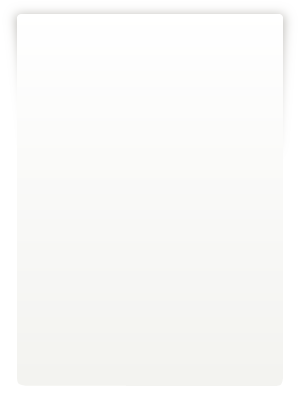
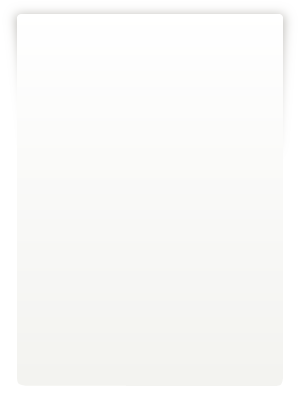
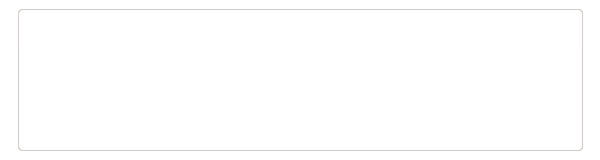
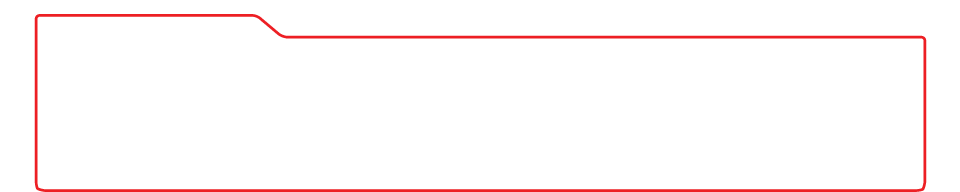
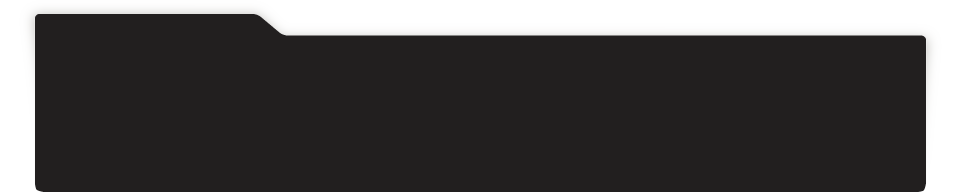
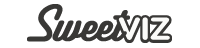
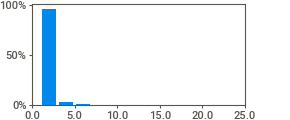
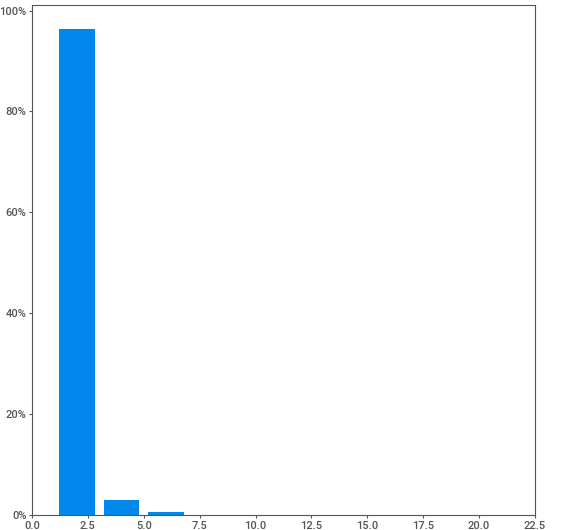
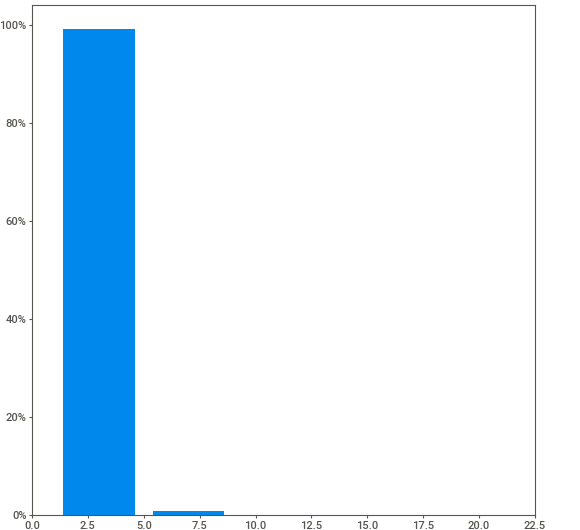
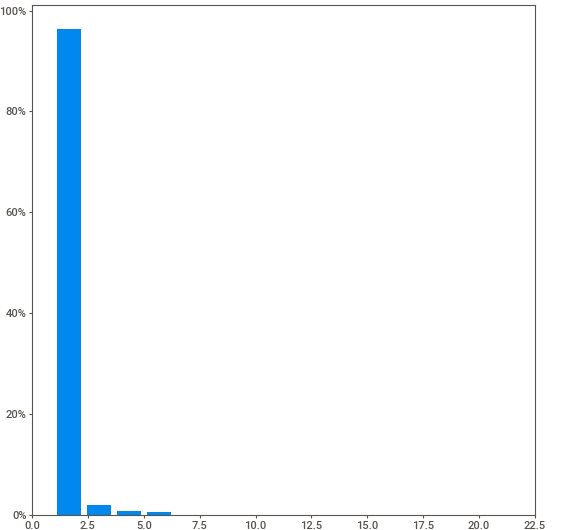
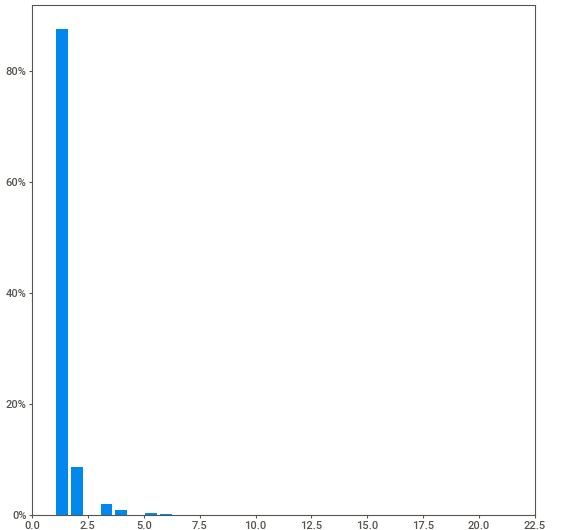
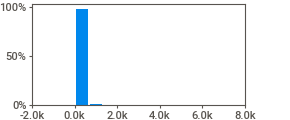
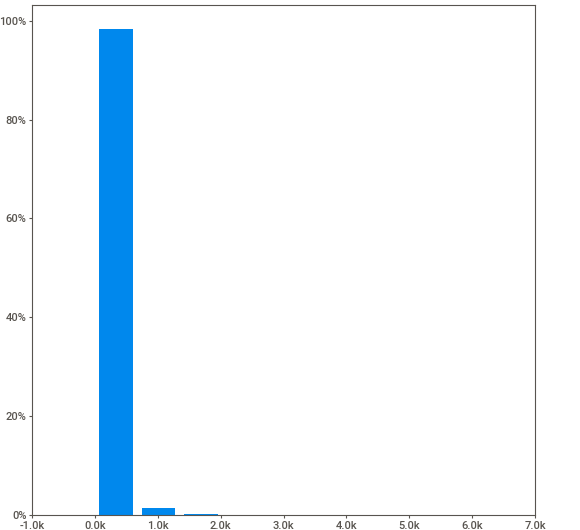
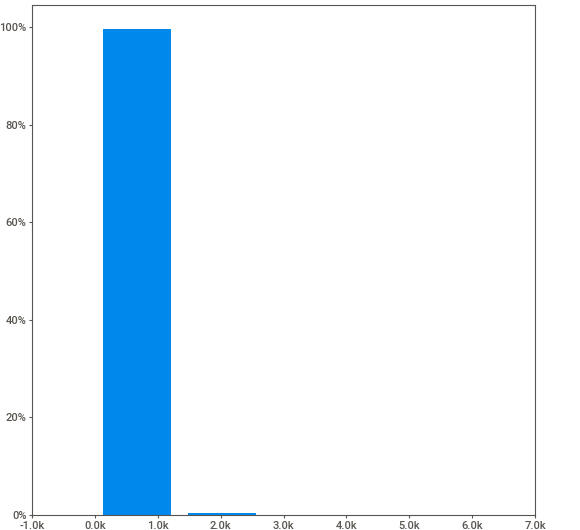
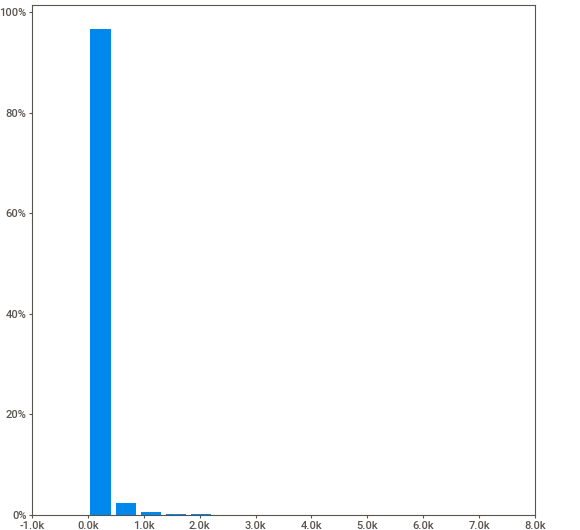
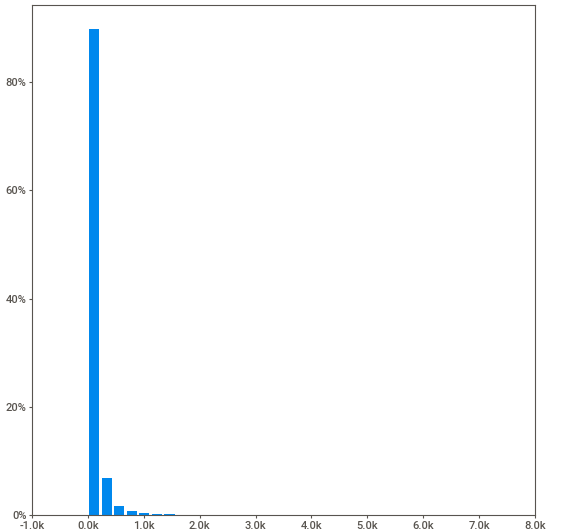
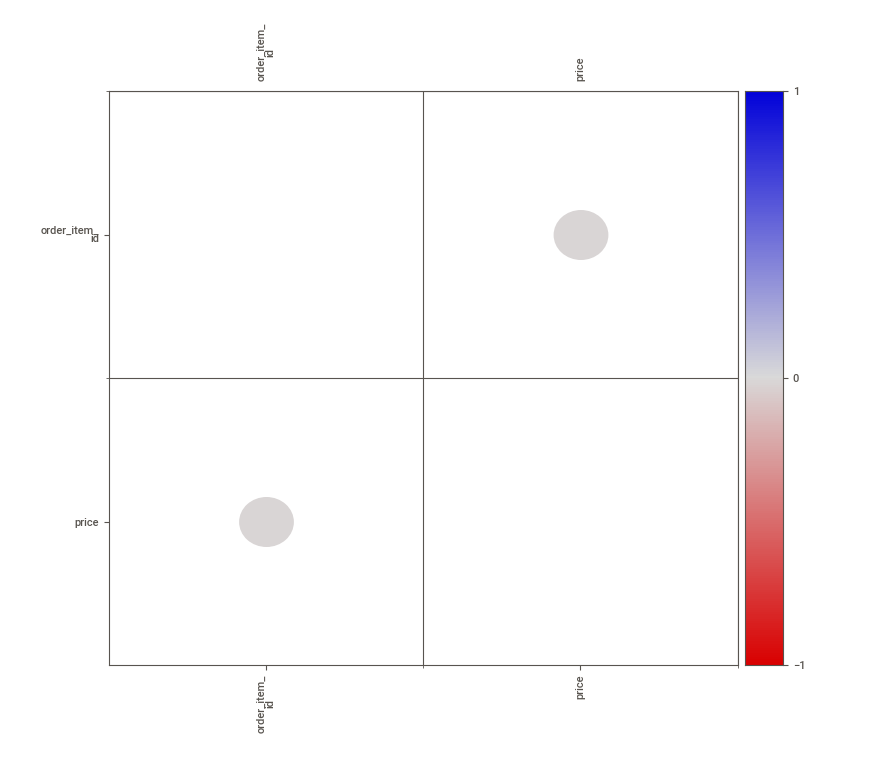
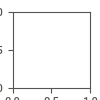

In [2293]:
analise = sv.analyze(source = dtOrderItems)
analise.show_notebook()

### Order Reviews

In [2294]:
dtOrderReviews

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4


In [2295]:
dtOrderReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     99224 non-null  object
 1   order_id      99224 non-null  object
 2   review_score  99224 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [2296]:
dtOrderReviews.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [2297]:
dtOrderReviews.describe(include = 'object')

,review_id,order_id
count,99224,99224
unique,98410,98673
top,70509c441d994fa03d6c1457930c9024,03c939fd7fd3b38f8485a0f95798f1f6
freq,3,3


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



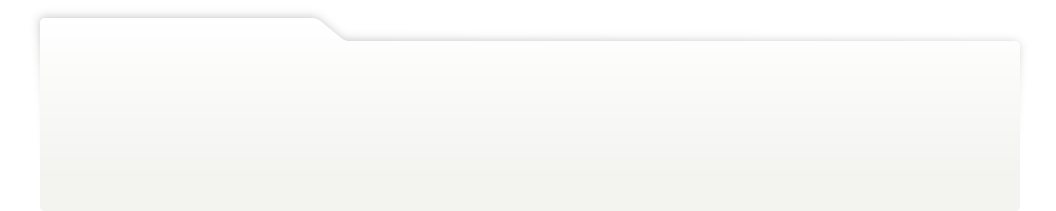
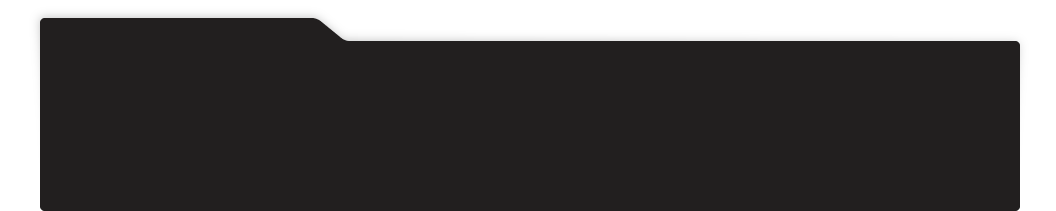
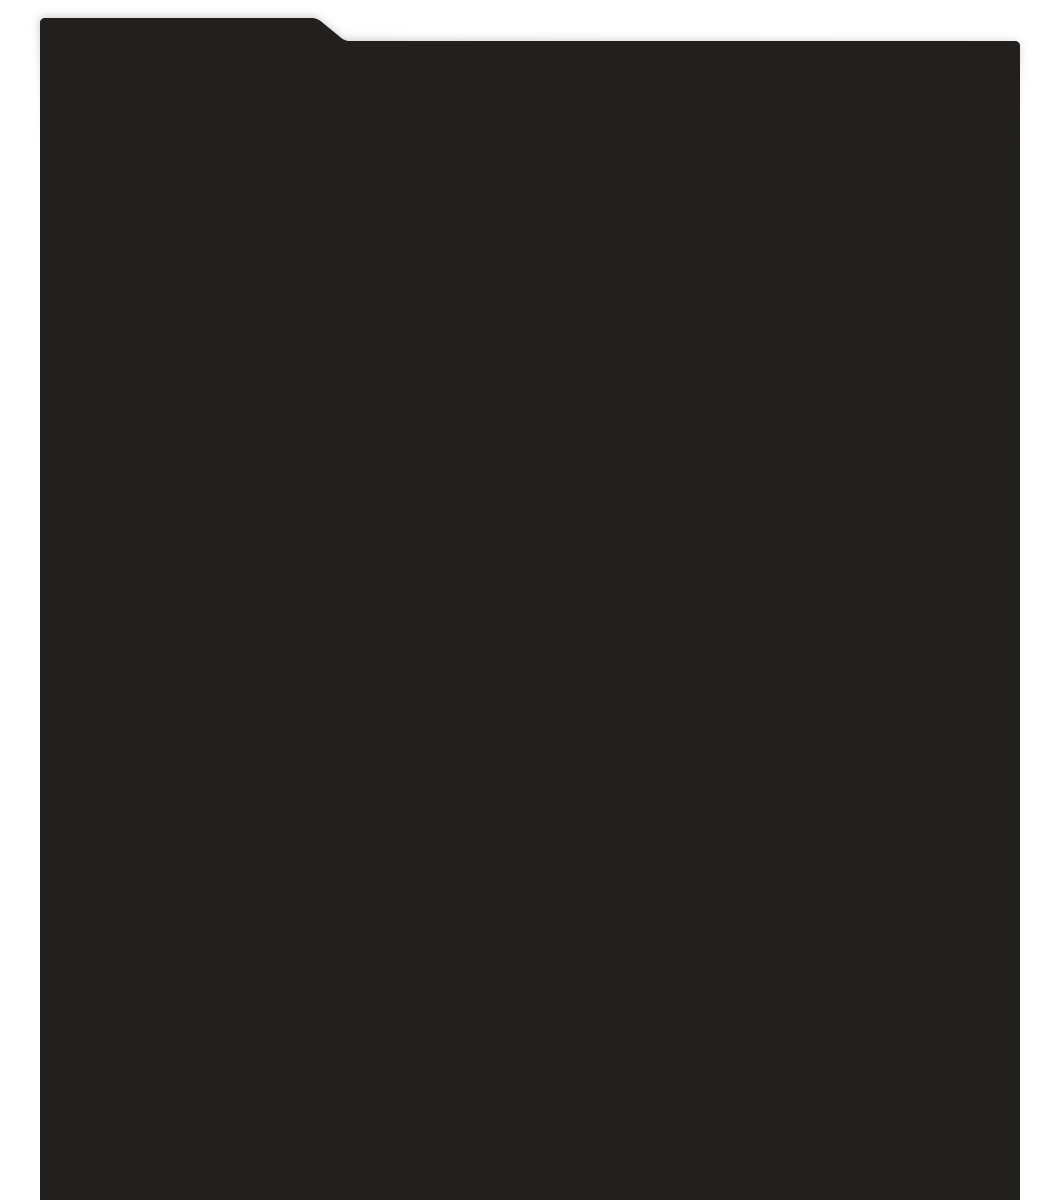
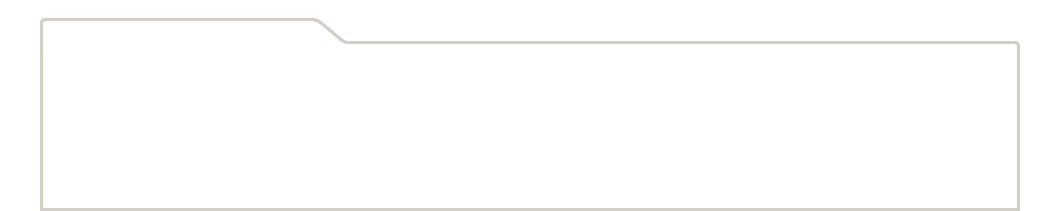
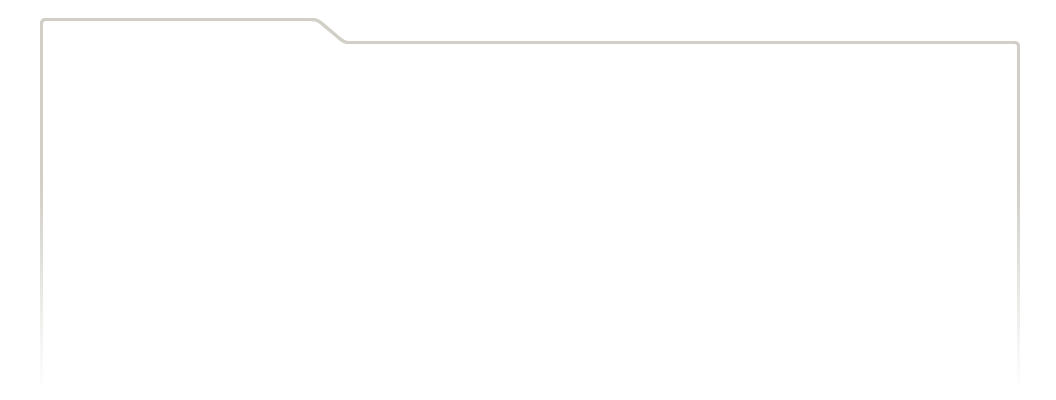
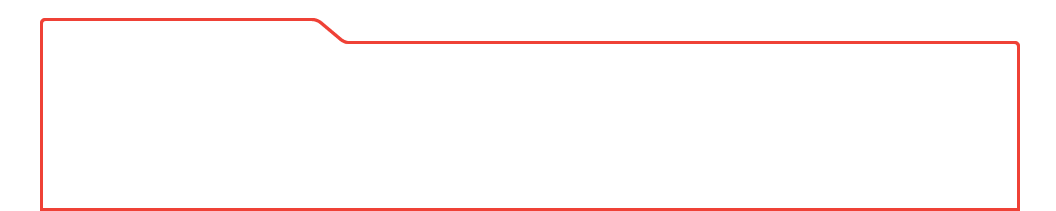
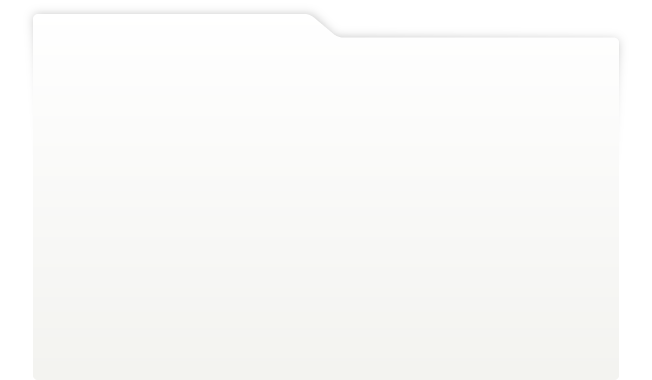
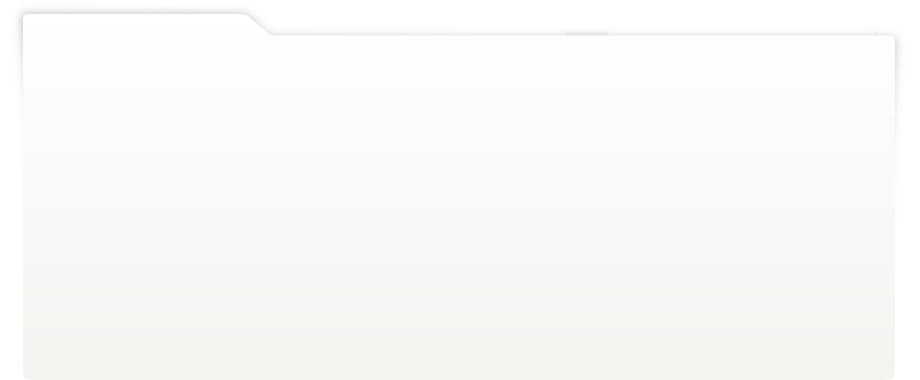
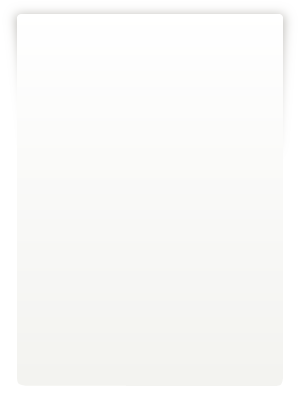
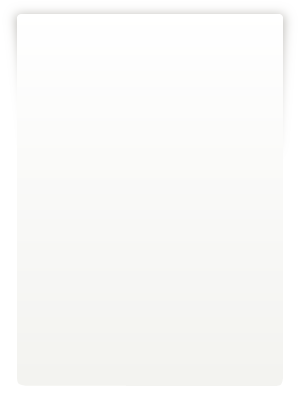
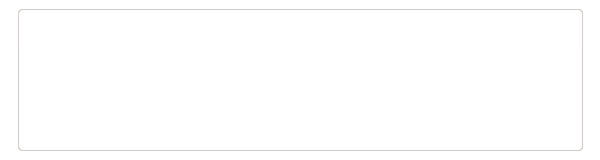
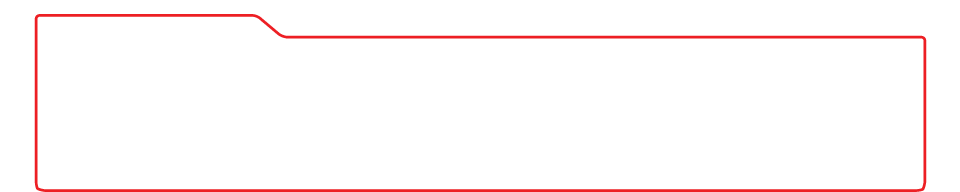
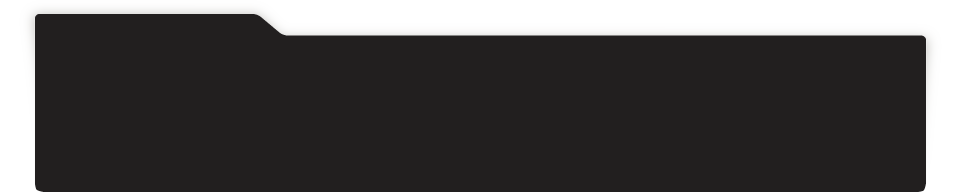
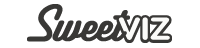
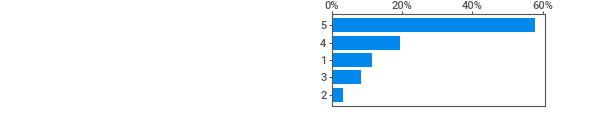
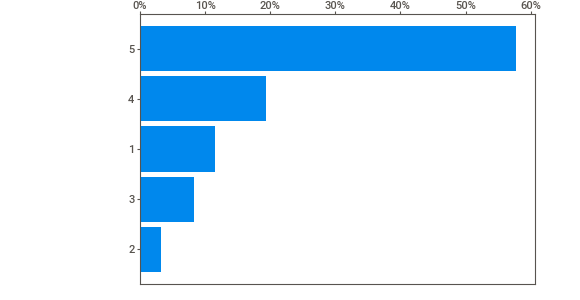
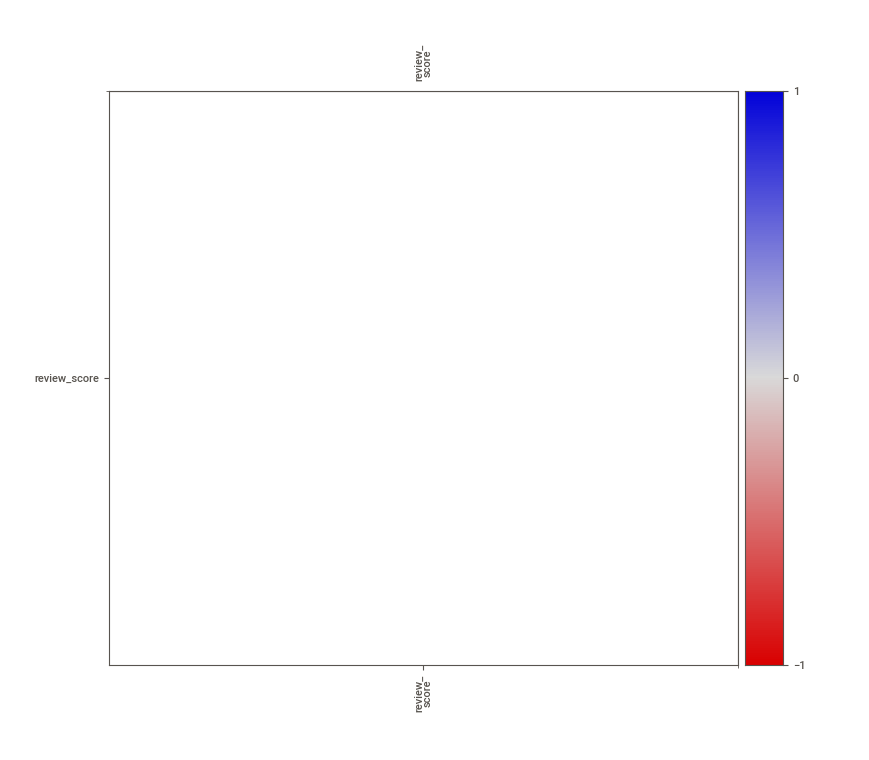
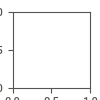

In [2298]:
analise = sv.analyze(source = dtOrderReviews)
analise.show_notebook()

### Orders

In [2299]:
dtOrders

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered


In [2300]:
dtOrders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   order_id      99441 non-null  object
 1   customer_id   99441 non-null  object
 2   order_status  99441 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [2301]:
dtOrders.describe()

,order_id,customer_id,order_status
count,99441,99441,99441
unique,99441,99441,8
top,f8e721184f691c61dc23e54beaeff557,c695e0ab88c84c2ab6ea7e5208a22230,delivered
freq,1,1,96478


In [2302]:
dtOrders.describe(include = 'object')

,order_id,customer_id,order_status
count,99441,99441,99441
unique,99441,99441,8
top,f8e721184f691c61dc23e54beaeff557,c695e0ab88c84c2ab6ea7e5208a22230,delivered
freq,1,1,96478


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



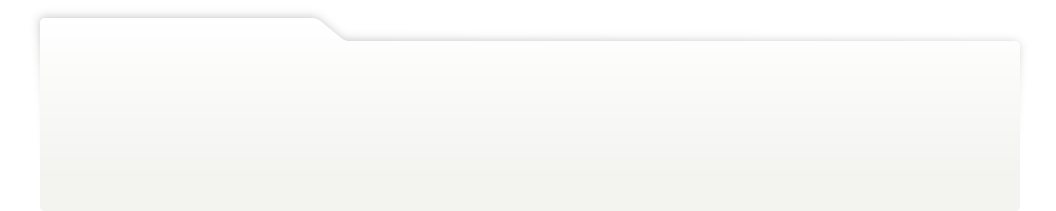
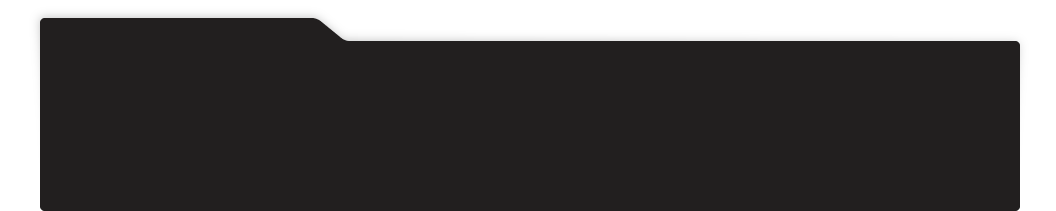
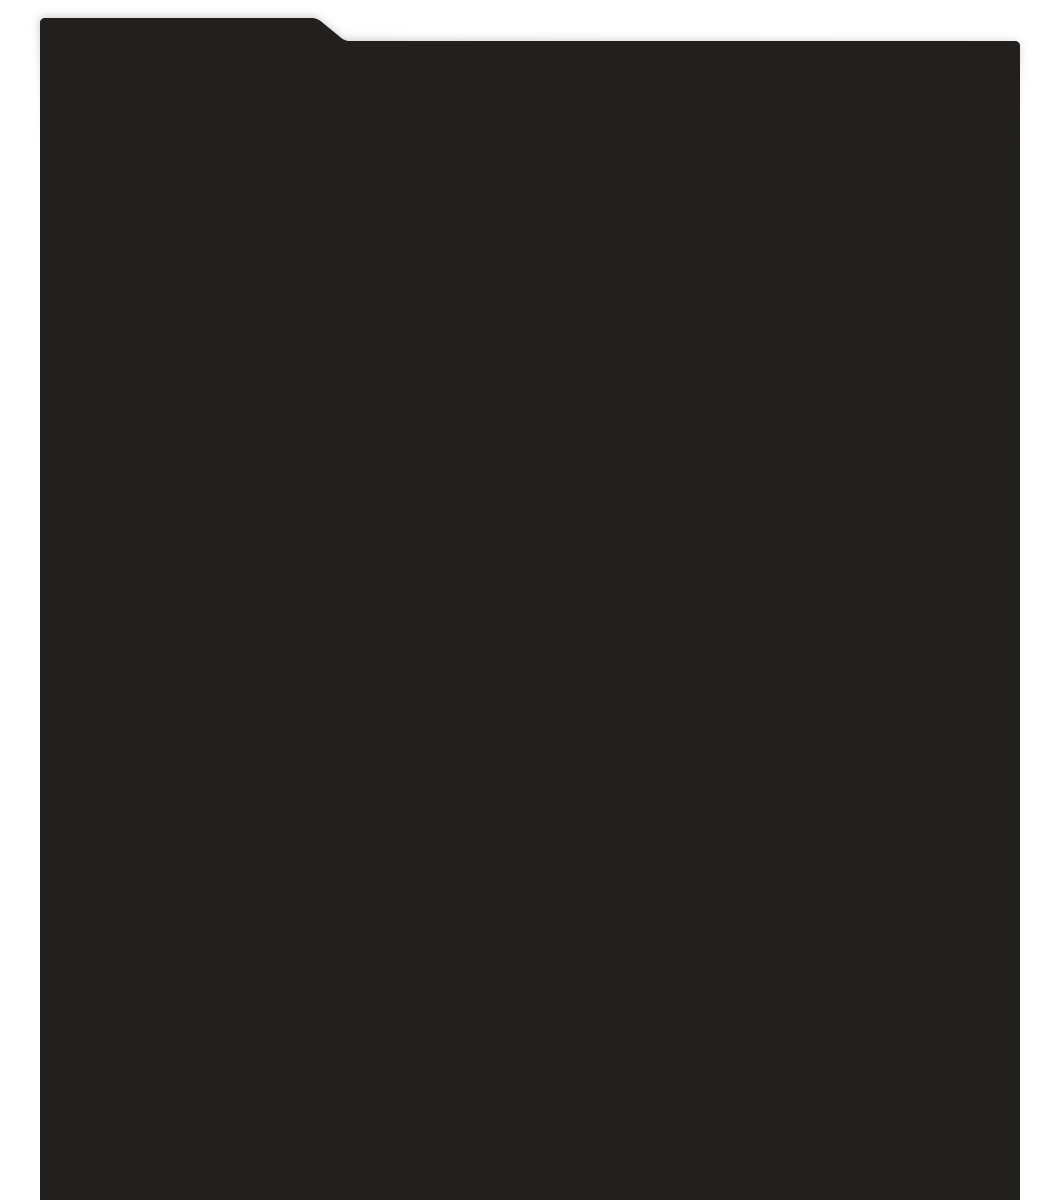
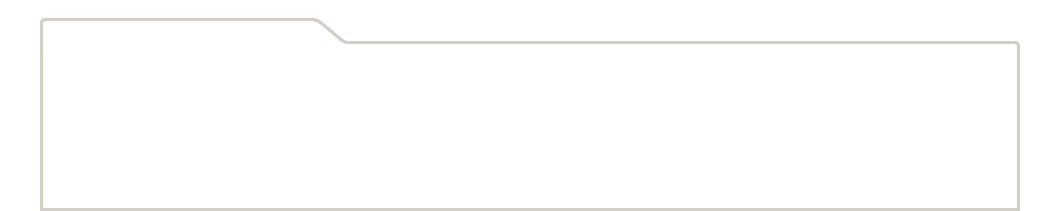
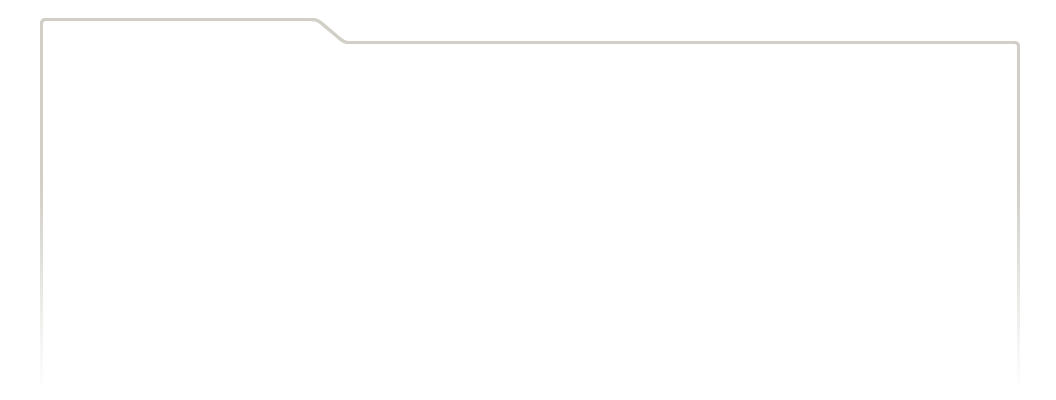
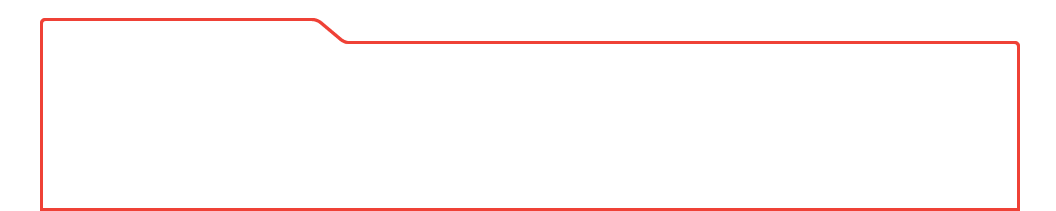
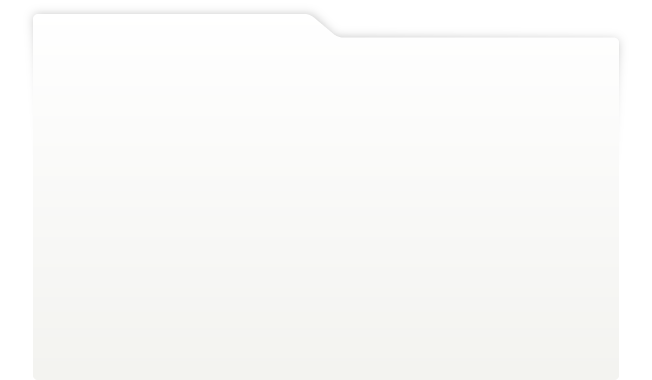
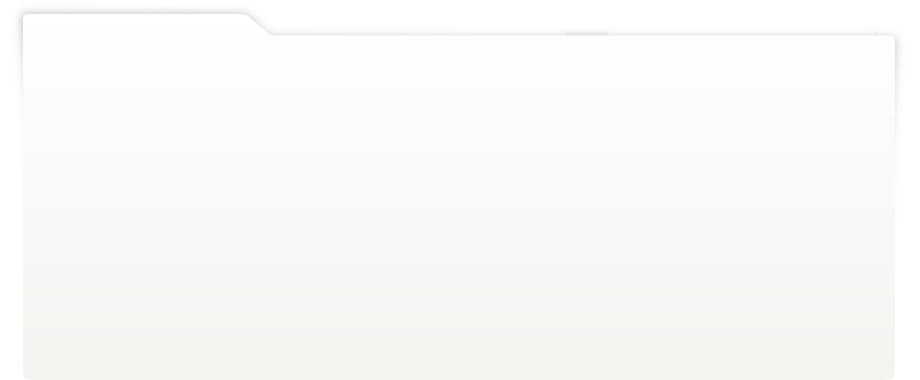
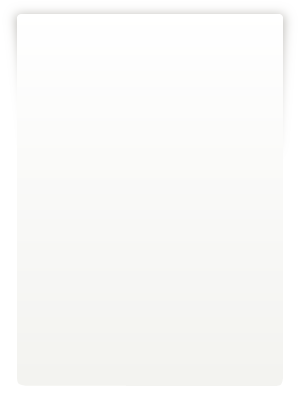
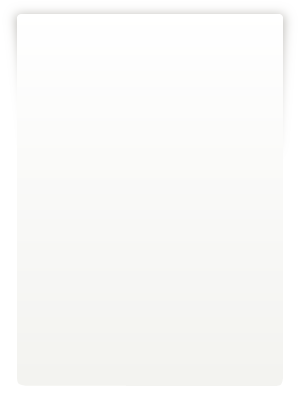
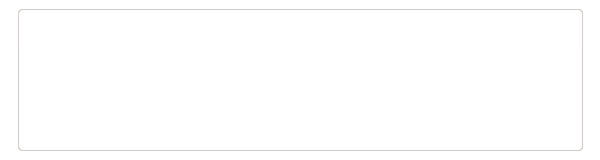
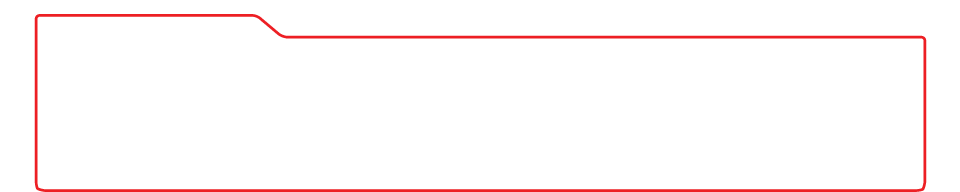
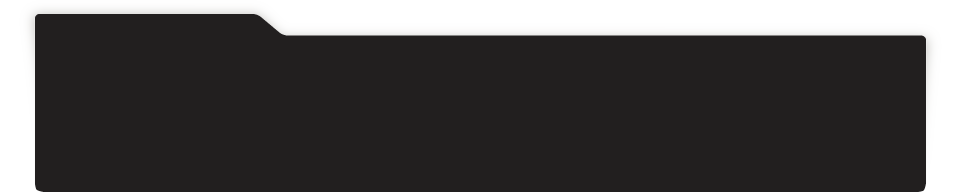
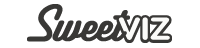
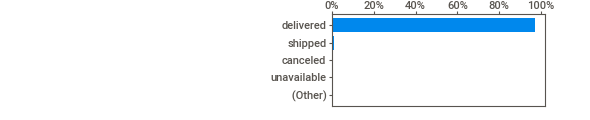
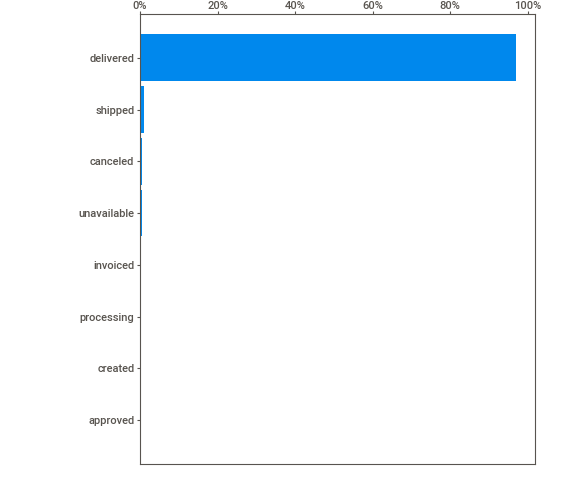
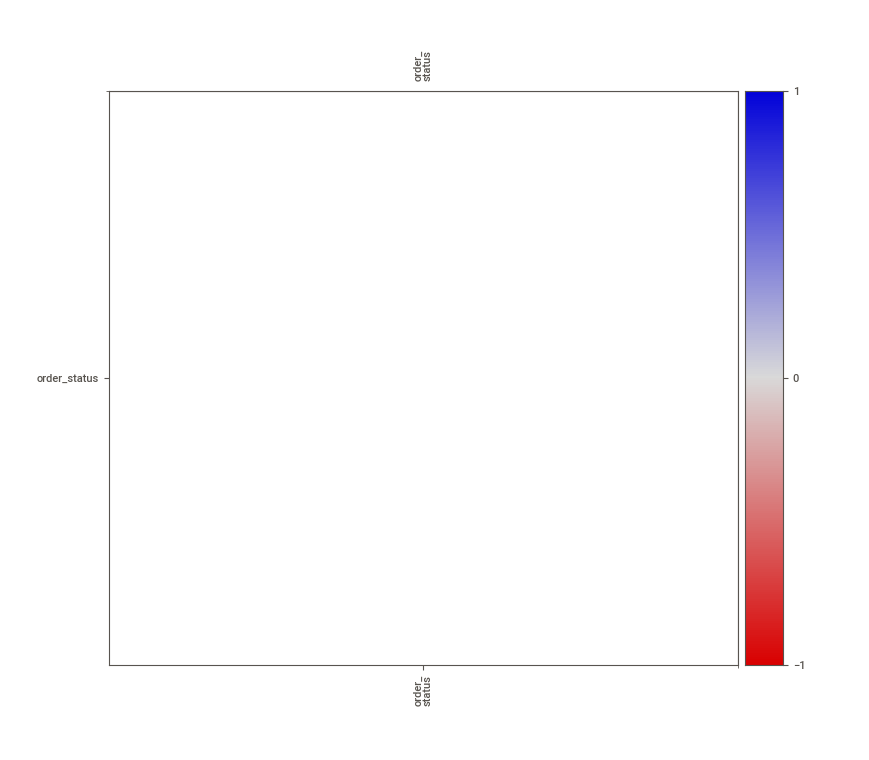
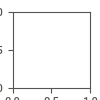

In [2303]:
analise = sv.analyze(source = dtOrders)
analise.show_notebook()

### Products

In [2304]:
dtProducts

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,700.0,31.0,13.0,20.0


In [2305]:
dtProducts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_weight_g            32949 non-null  float64
 5   product_length_cm           32949 non-null  float64
 6   product_height_cm           32949 non-null  float64
 7   product_width_cm            32949 non-null  float64
dtypes: float64(6), object(2)
memory usage: 2.0+ MB


In [2306]:
dtProducts.describe()

,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,40425.000000,105.000000,105.000000,118.000000


In [2307]:
dtProducts.describe(include = 'object')

,product_id,product_category_name
count,32951,32341
unique,32951,73
top,aac3cc525702d53c8a2f4733ed214098,cama_mesa_banho
freq,1,3029


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



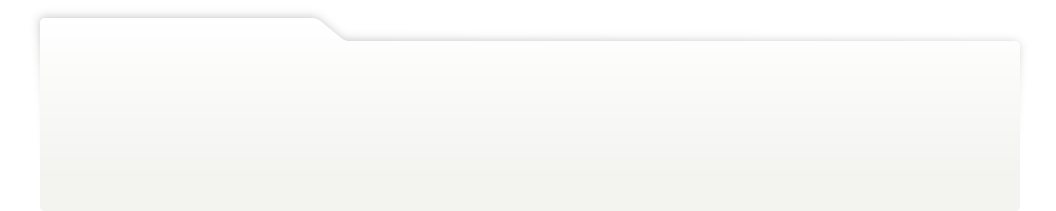
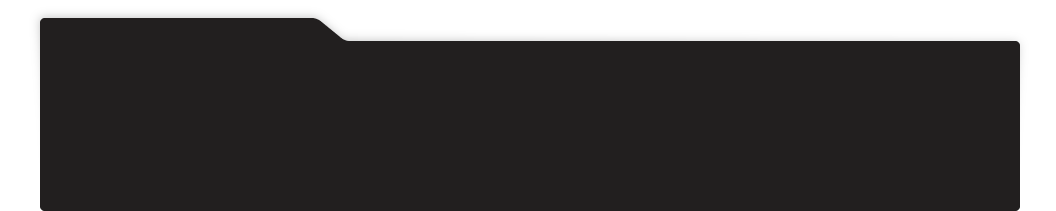
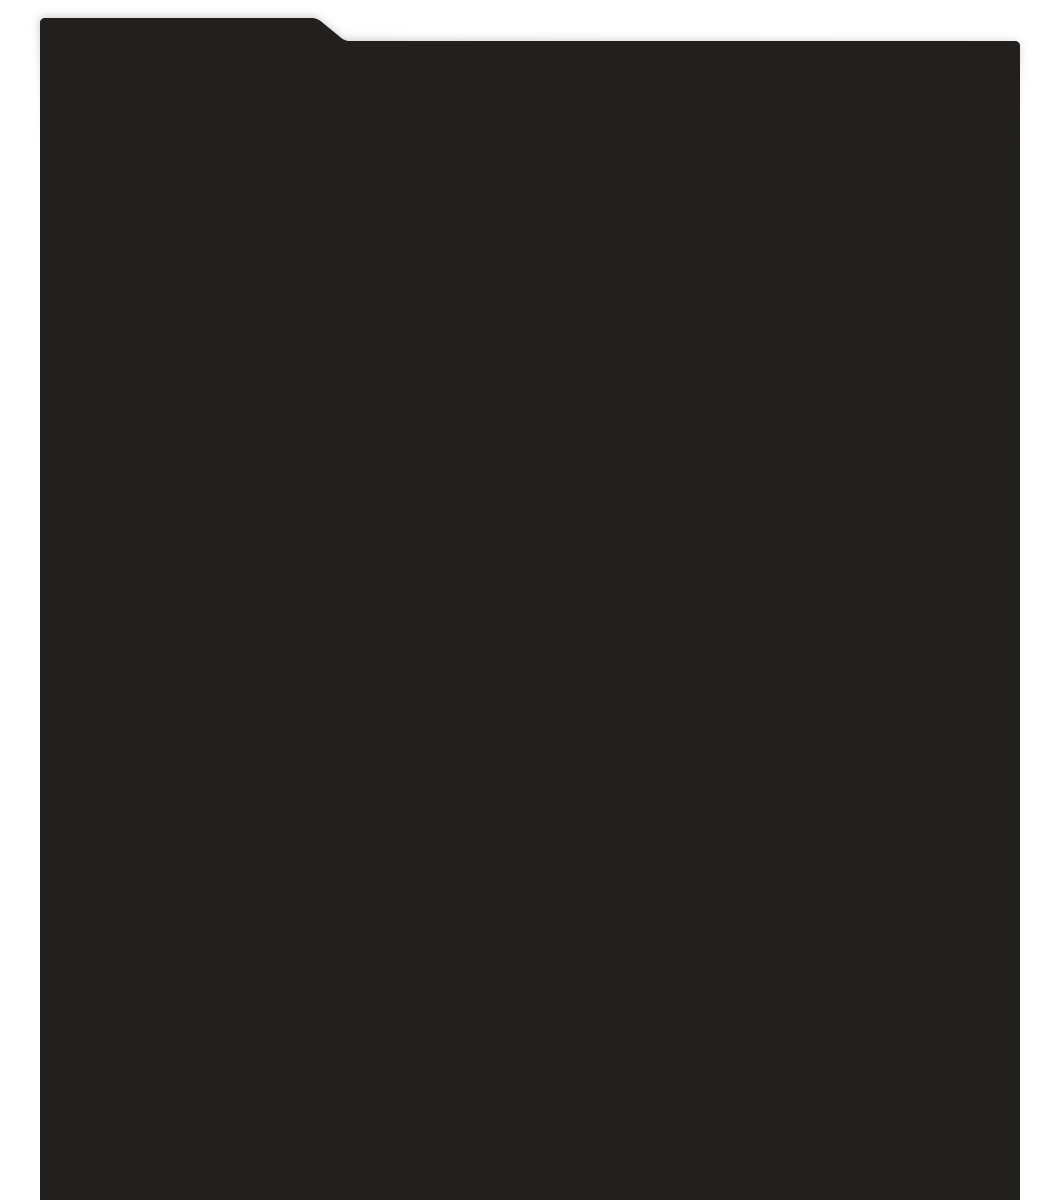
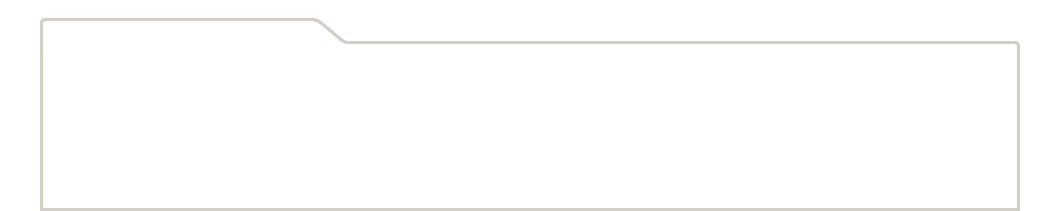
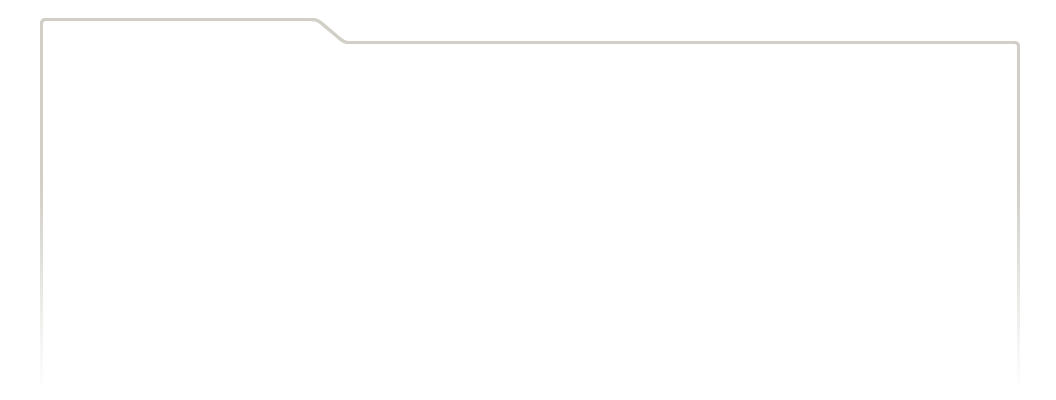
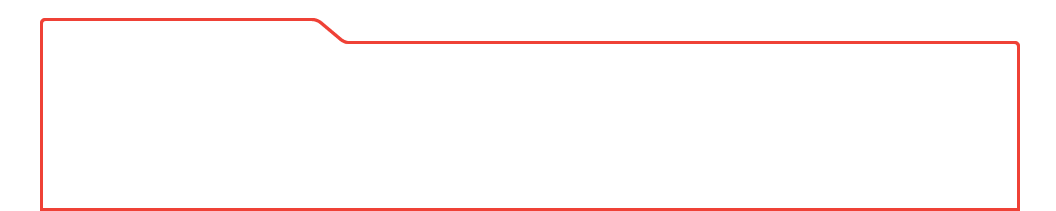
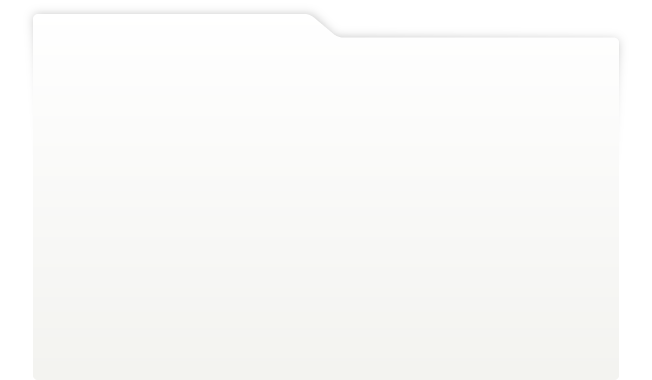
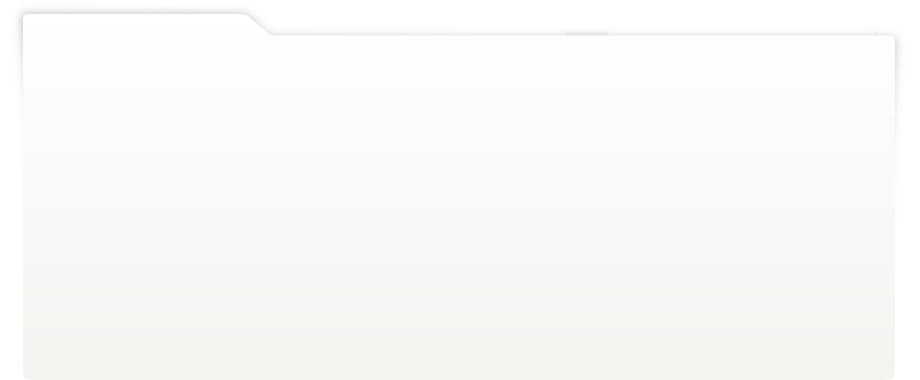
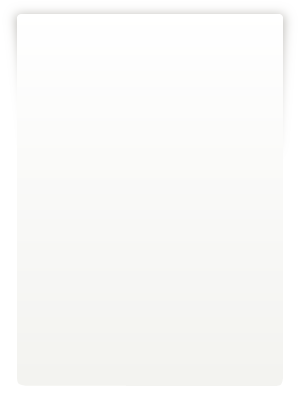
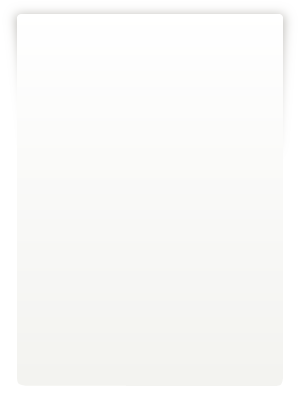
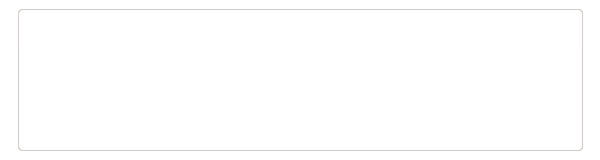
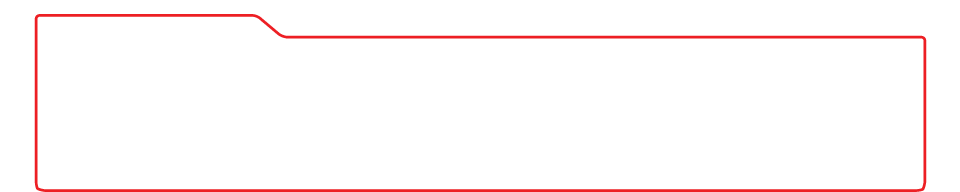
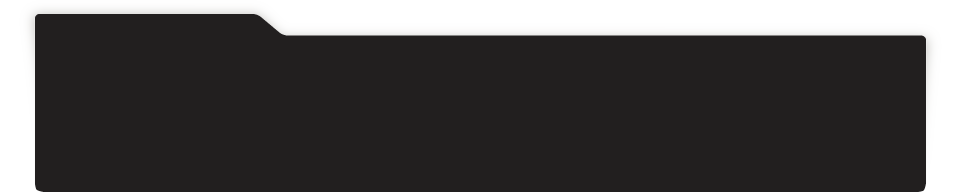
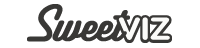
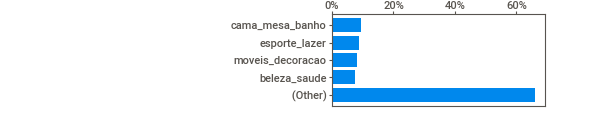
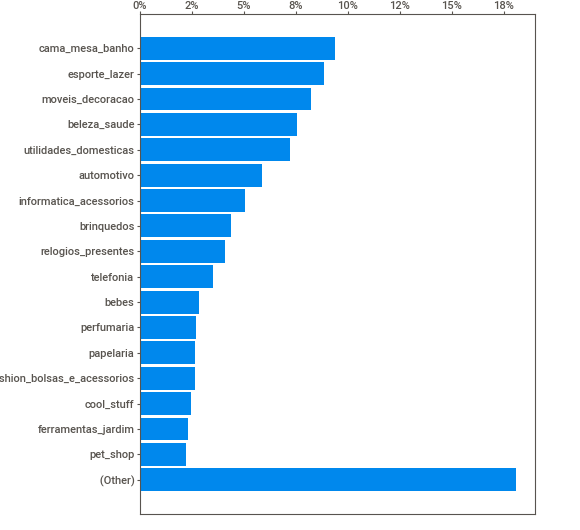
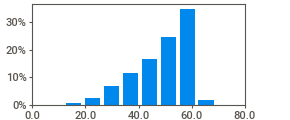
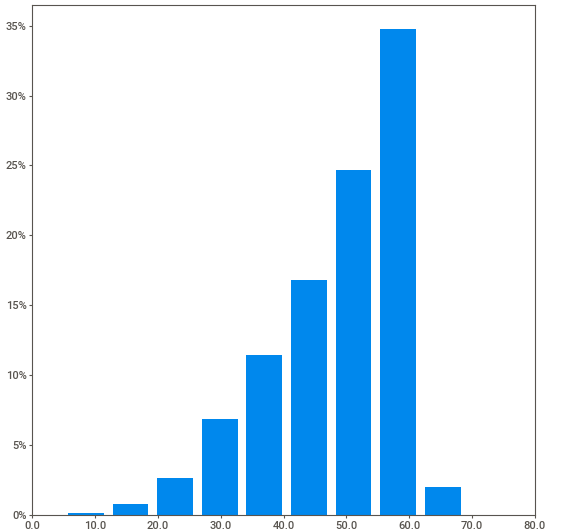
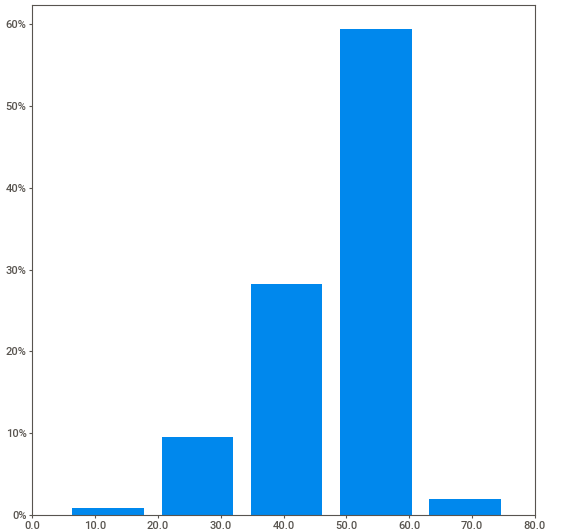
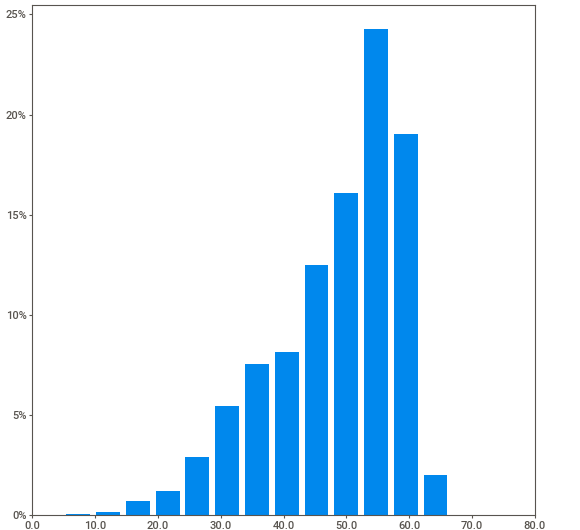
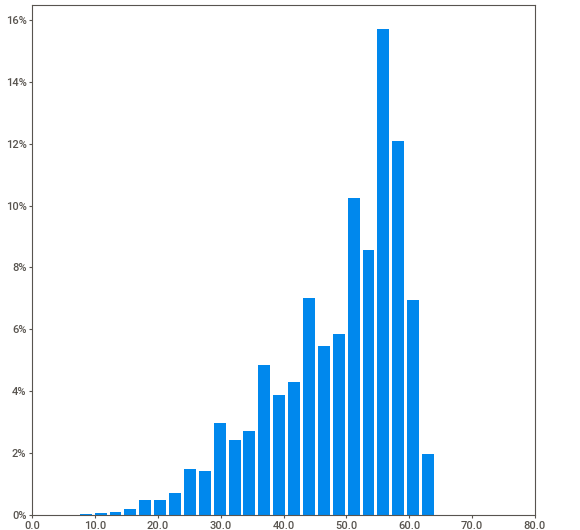
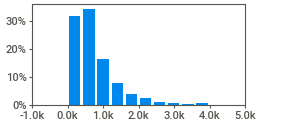
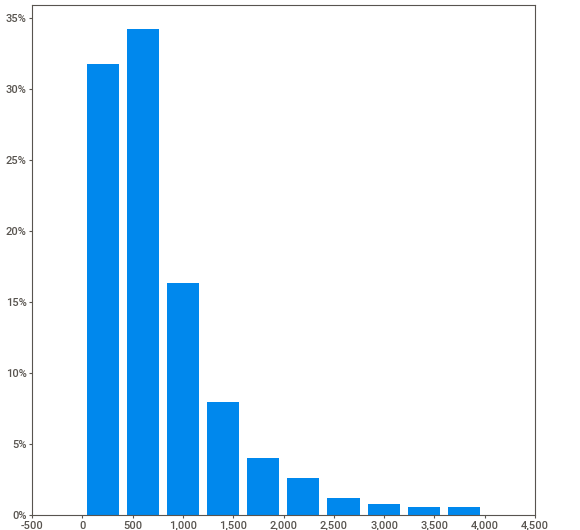
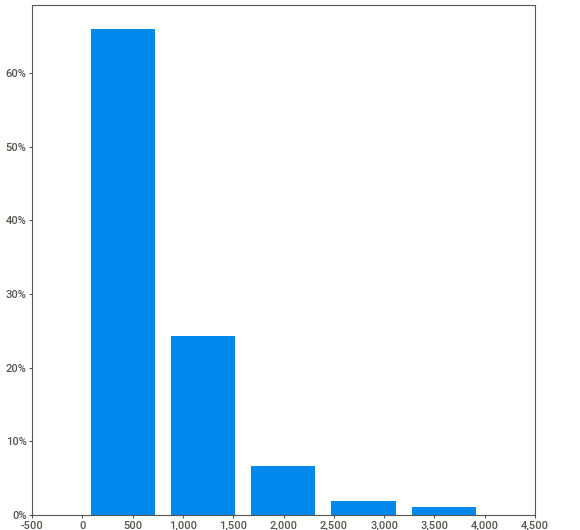
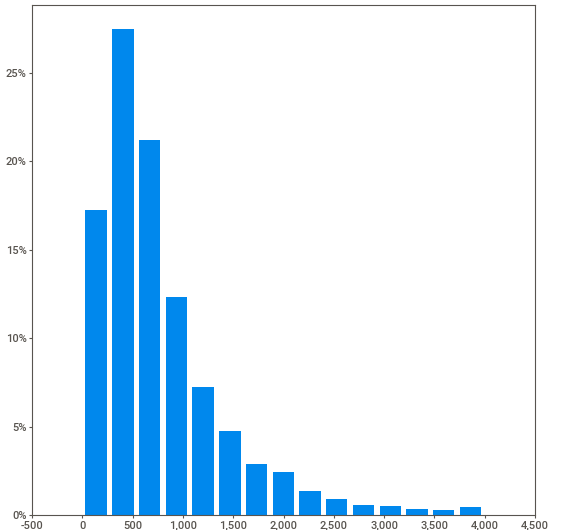
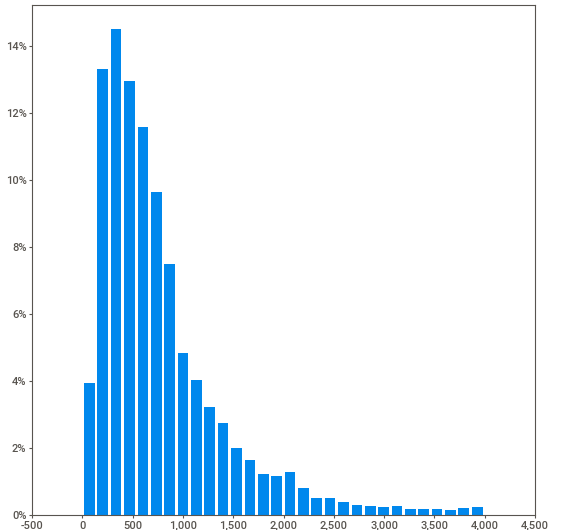
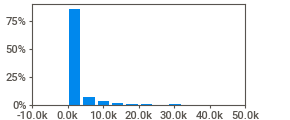
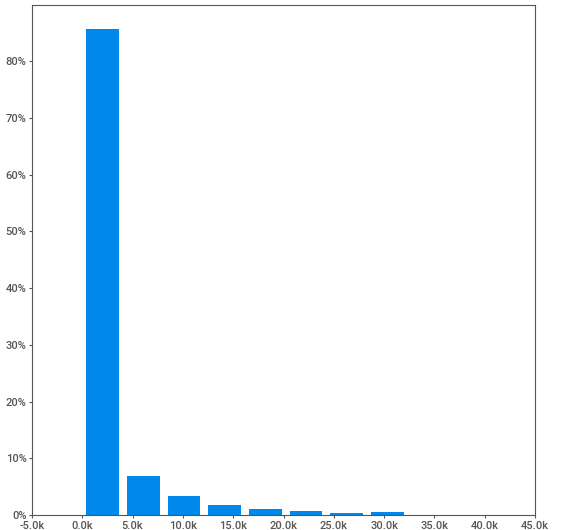
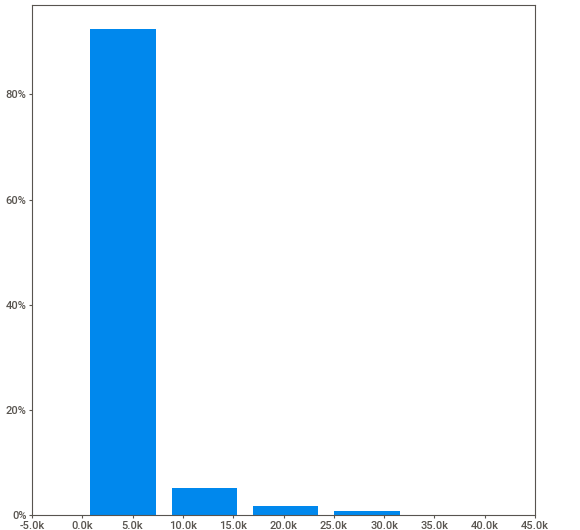
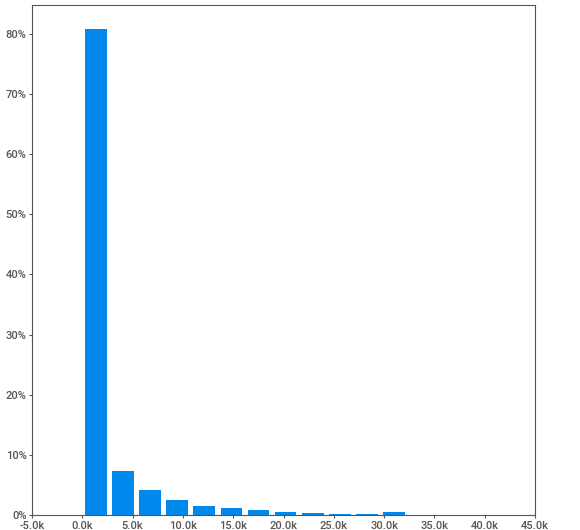
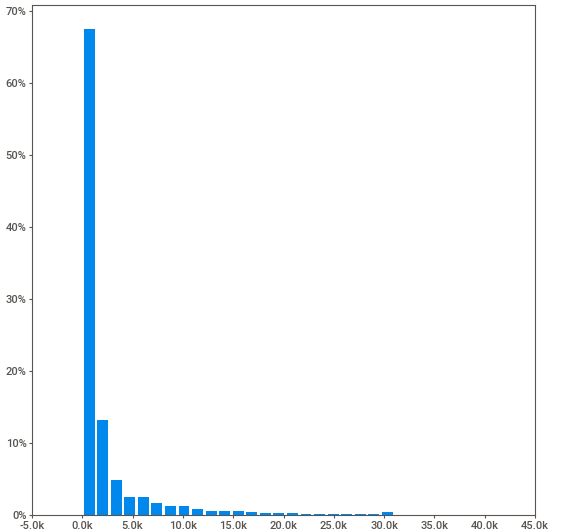
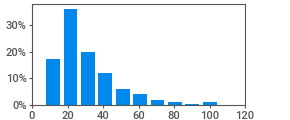
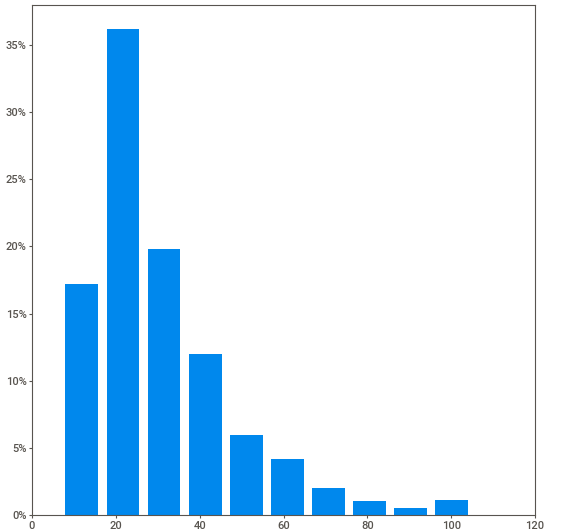
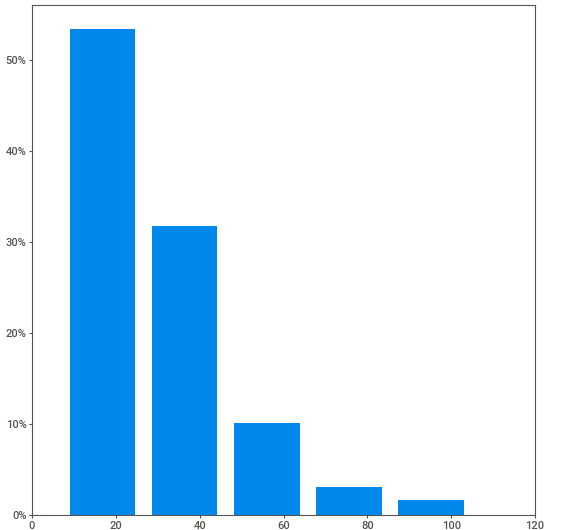
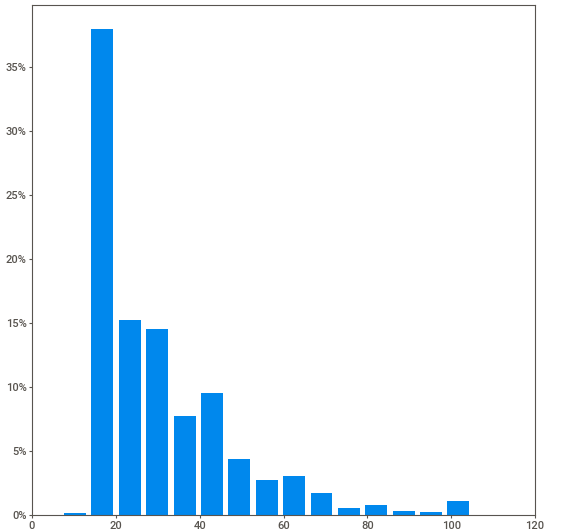
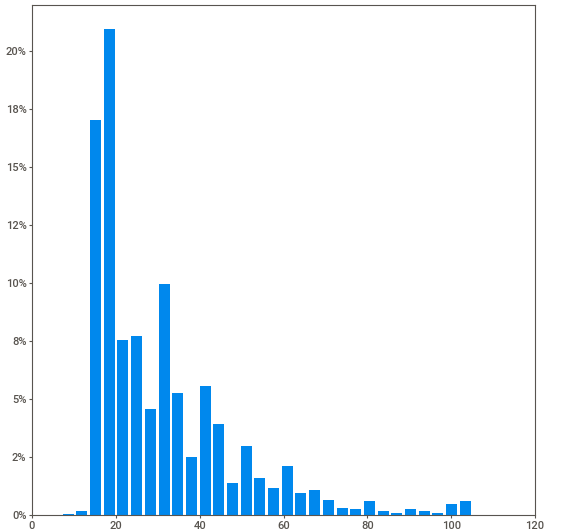
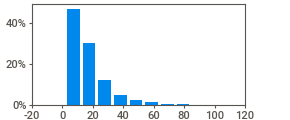
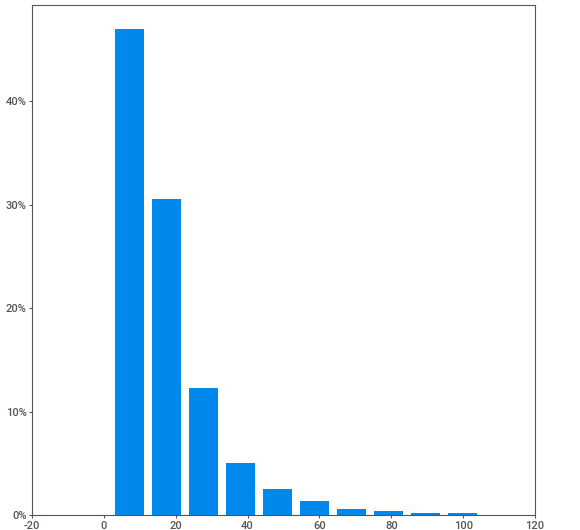
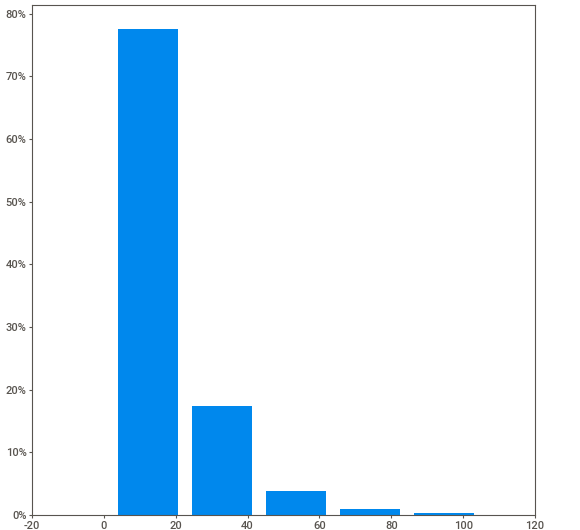
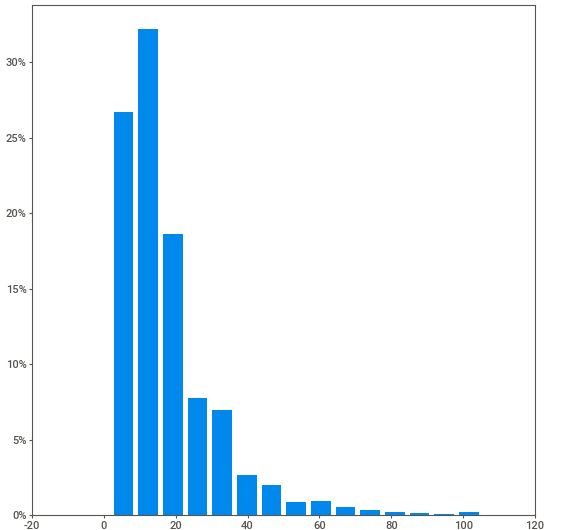
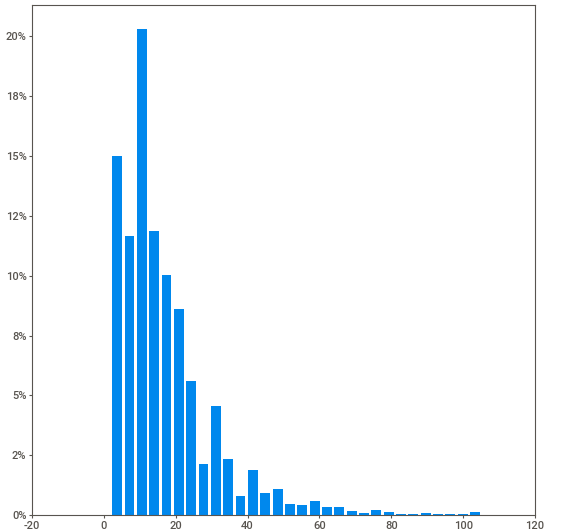
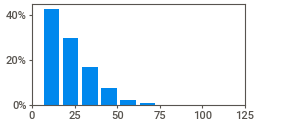
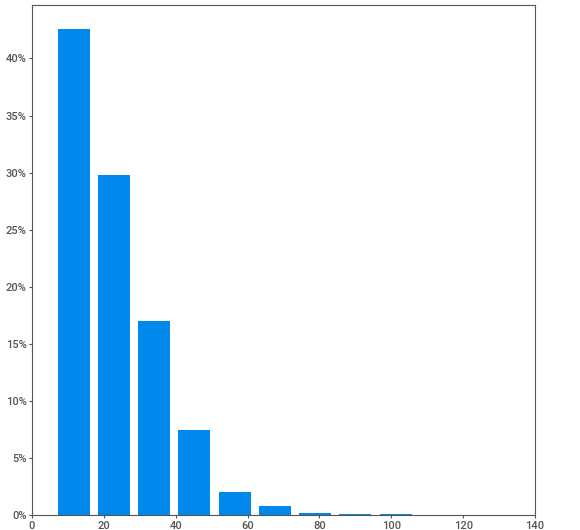
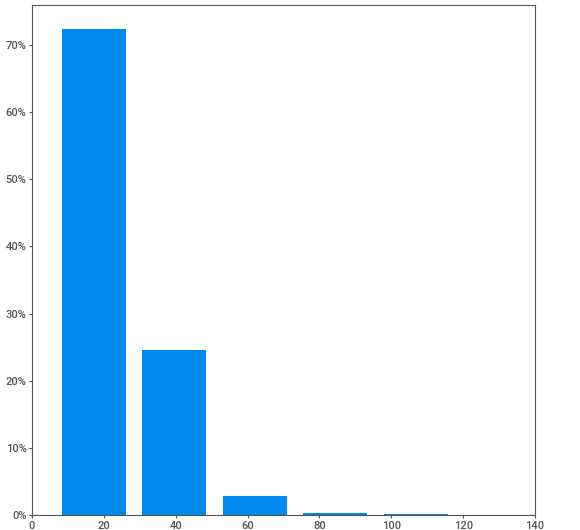
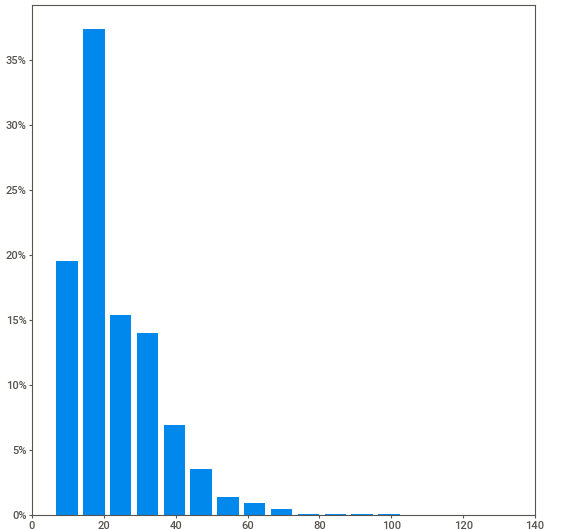
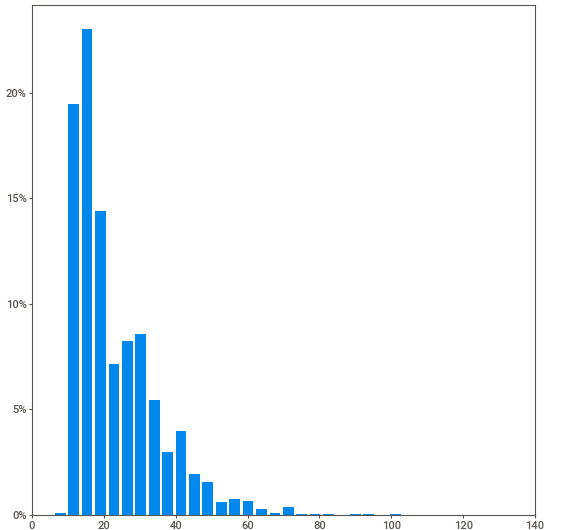
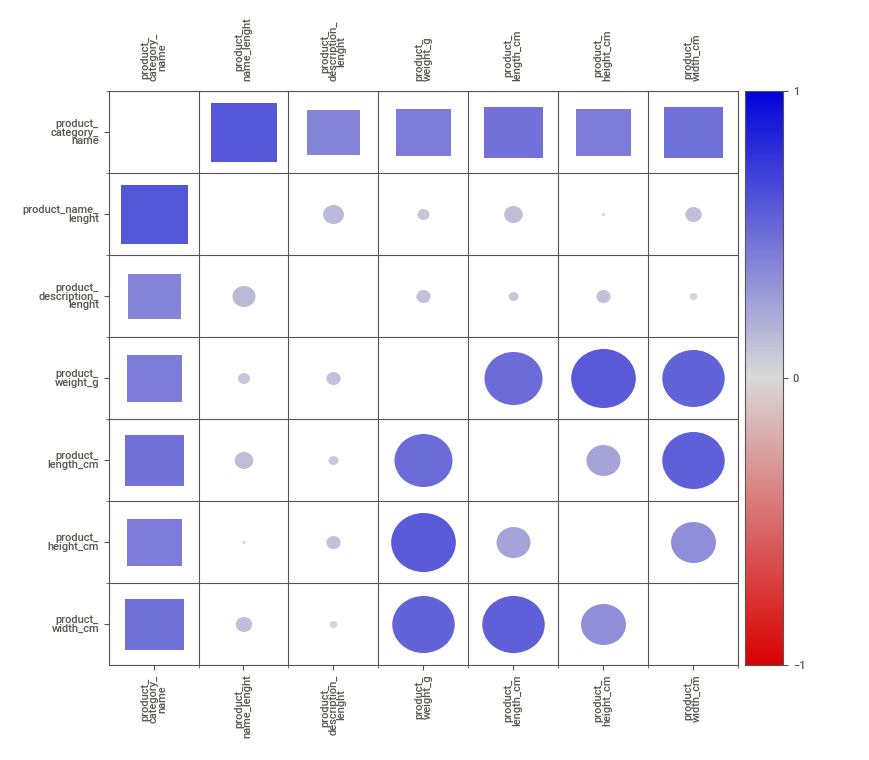
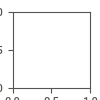

In [2308]:
analise = sv.analyze(source = dtProducts)
analise.show_notebook()

## Tratamento de Dados

### Order Items

In [2309]:
dtOrderItems

,order_id,order_item_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90
...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,299.99
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,350.00
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,99.90
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,55.99


In [2310]:
dtOrderItems = dtOrderItems.drop(columns='order_item_id')

In [2311]:
dtOrderItems = EliminarDuplicadas(dtOrderItems)

In [2312]:
dtOrderItems.shape

(102425, 3)

#### Análise de correspondência com as outras tabelas

In [2313]:
Corresp(dtOrders, dtOrderItems, 'order_id')

Valores de order_id não inclusos no primeiro dataset: 775
Valores de order_id não inclusos no segundo dataset: 0


In [2314]:
Corresp(dtProducts, dtOrderItems, 'product_id')

Valores de product_id não inclusos no primeiro dataset: 0
Valores de product_id não inclusos no segundo dataset: 0


#### Análise de outliers na coluna preço

<AxesSubplot:xlabel='price'>

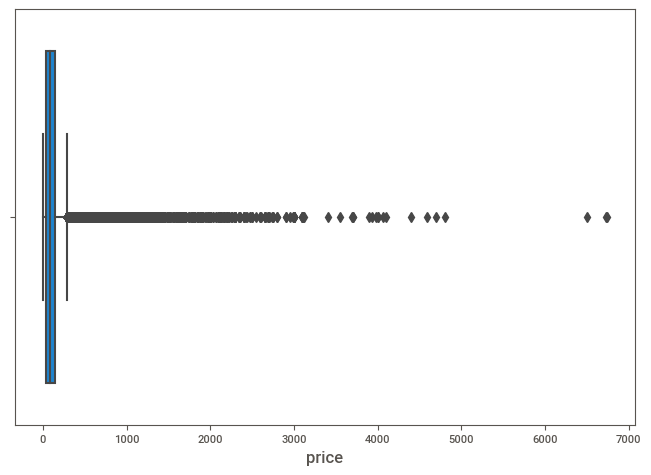

In [2315]:
sns.boxplot(x=dtOrderItems["price"])

In [2316]:
dtOrderItems["price"].mean()

124.42200634622918

In [2317]:
dtOrderItems["price"] = EliminarOutliers(dtOrderItems["price"])

<AxesSubplot:xlabel='price'>

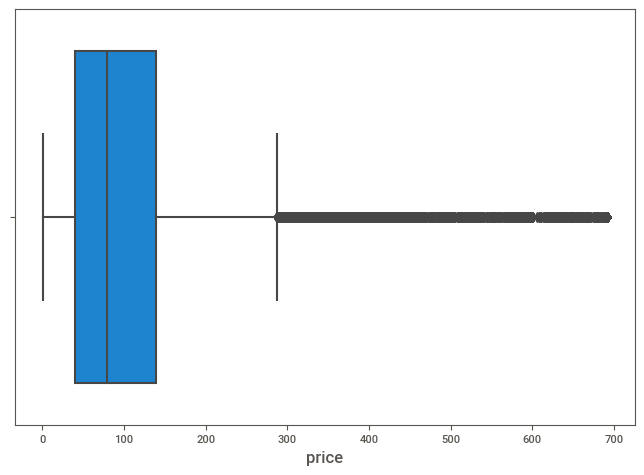

In [2318]:
sns.boxplot(x=dtOrderItems["price"])

<AxesSubplot:xlabel='price', ylabel='Count'>

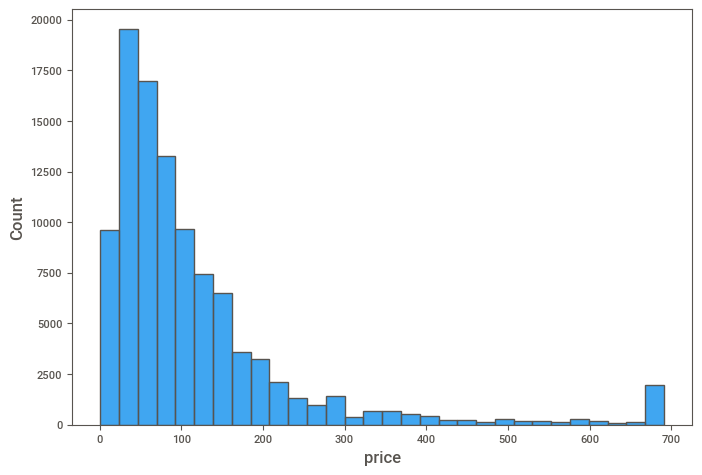

In [2319]:
sns.histplot(data=dtOrderItems["price"], bins=30)

### Order Reviews

In [2320]:
dtOrderReviews

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4


In [2321]:
dtOrderReviews = EliminarDuplicadas(dtOrderReviews)

In [2322]:
dtOrderReviews.shape

(99224, 3)

#### Análise de correspondência com as outras tabelas

In [2323]:
Corresp(dtOrders, dtOrderReviews, 'order_id')

Valores de order_id não inclusos no primeiro dataset: 768
Valores de order_id não inclusos no segundo dataset: 0


#### Análise de outliers

### Orders

In [2324]:
dtOrders

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered


In [2325]:
dtOrders = EliminarDuplicadas(dtOrders)

In [2326]:
dtOrders.shape

(99441, 3)

#### Análise de consistência na coluna status

In [2327]:
dtOrders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [2328]:
len(dtOrders['order_status'].unique())

8

In [2329]:
dtOrders['order_status'].isna().value_counts()

False    99441
Name: order_status, dtype: int64

### Products

In [2330]:
dtProducts

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,700.0,31.0,13.0,20.0


In [2331]:
dtProducts = EliminarDuplicadas(dtProducts)

In [2332]:
dtProducts.shape

(32951, 8)

#### Análise de consistência na coluna de categoria

In [2333]:
dtProducts['product_category_name'].value_counts()

cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 73, dtype: int64

In [2334]:
len(dtProducts['product_category_name'].unique())

74

In [2335]:
dtProducts['product_category_name'].isna().value_counts()

False    32341
True       610
Name: product_category_name, dtype: int64

In [2336]:
dtProducts['product_category_name'].fillna('other', inplace=True)

#### Análise de consistência na coluna de tamanho do nome

<AxesSubplot:xlabel='product_name_lenght'>

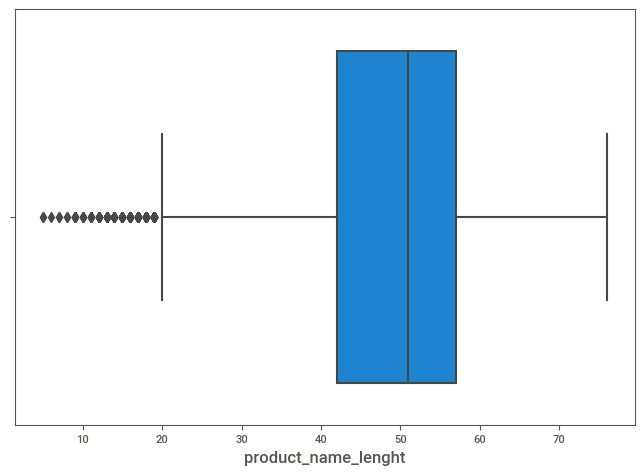

In [2337]:
sns.boxplot(x=dtProducts["product_name_lenght"])

In [2338]:
dtProducts["product_name_lenght"].mean()

48.47694876472589

In [2339]:
dtProducts["product_name_lenght"] = EliminarOutliers(dtProducts["product_name_lenght"])

<AxesSubplot:xlabel='product_name_lenght'>

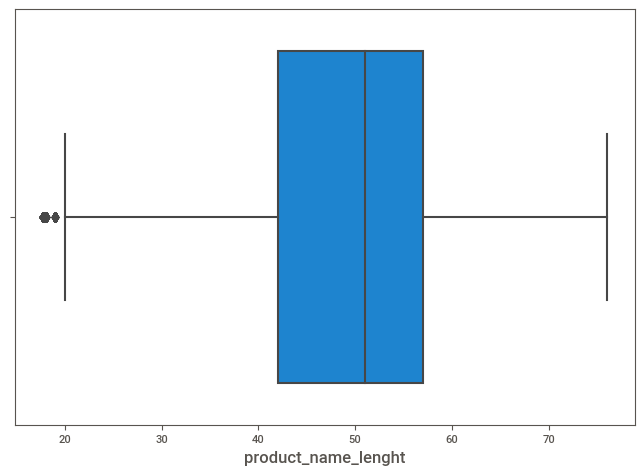

In [2340]:
sns.boxplot(x=dtProducts["product_name_lenght"])

<AxesSubplot:xlabel='product_name_lenght', ylabel='Count'>

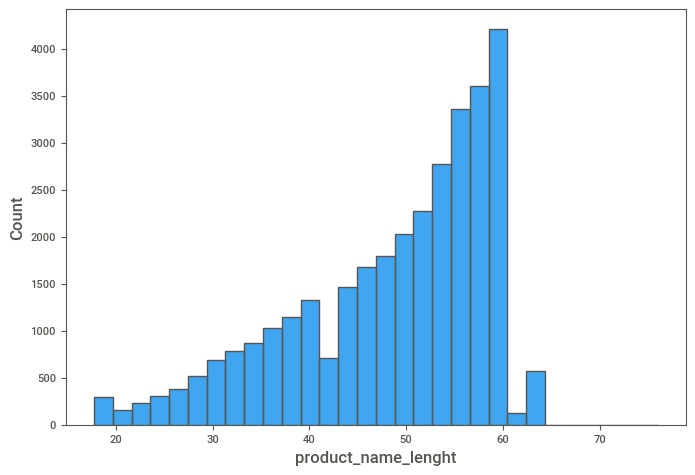

In [2341]:
sns.histplot(data=dtProducts["product_name_lenght"], bins=30)

In [2342]:
dtProducts['product_category_name'].value_counts()

cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 74, dtype: int64

In [2343]:
len(dtProducts['product_category_name'].unique())

74

In [2344]:
dtProducts['product_category_name'].isna().value_counts()

False    32951
Name: product_category_name, dtype: int64

#### Análise de consistência na coluna de tamanho da descrição

<AxesSubplot:xlabel='product_description_lenght'>

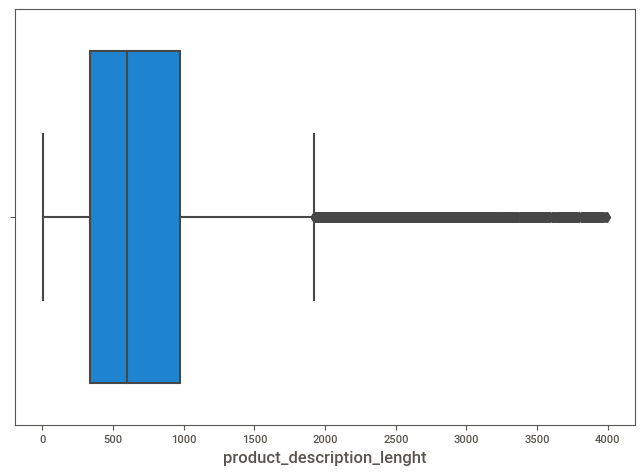

In [2345]:
sns.boxplot(x=dtProducts["product_description_lenght"])

In [2346]:
dtProducts["product_description_lenght"].mean()

771.4952846232337

In [2347]:
dtProducts["product_description_lenght"] = EliminarOutliers(dtProducts["product_description_lenght"])

<AxesSubplot:xlabel='product_description_lenght'>

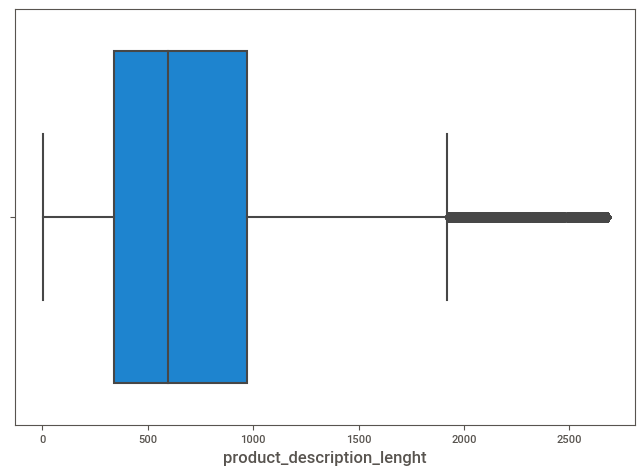

In [2348]:
sns.boxplot(x=dtProducts["product_description_lenght"])

<AxesSubplot:xlabel='product_description_lenght', ylabel='Count'>

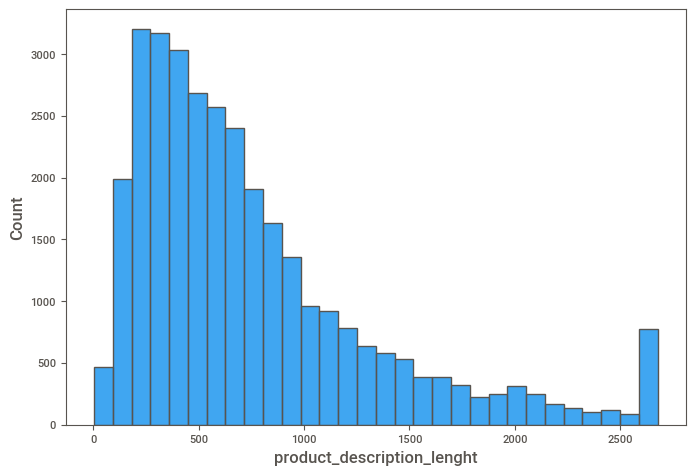

In [2349]:
sns.histplot(data=dtProducts["product_description_lenght"], bins=30)

#### Análise de consistência na coluna de peso

<AxesSubplot:xlabel='product_weight_g'>

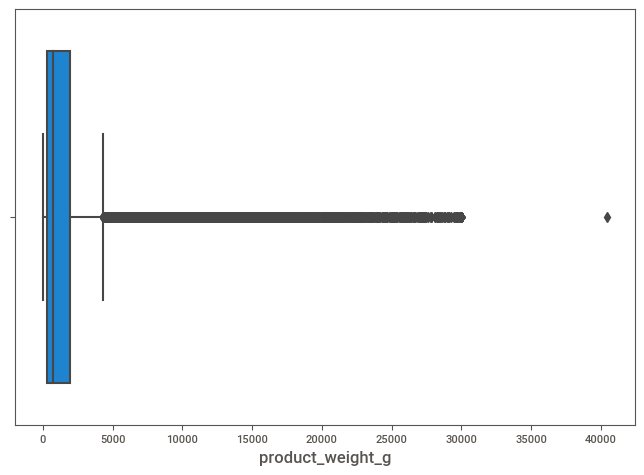

In [2350]:
sns.boxplot(x=dtProducts["product_weight_g"])

In [2351]:
dtProducts["product_weight_g"].mean()

2276.4724877841513

In [2352]:
dtProducts["product_weight_g"] = EliminarOutliers(dtProducts["product_weight_g"])

<AxesSubplot:xlabel='product_weight_g'>

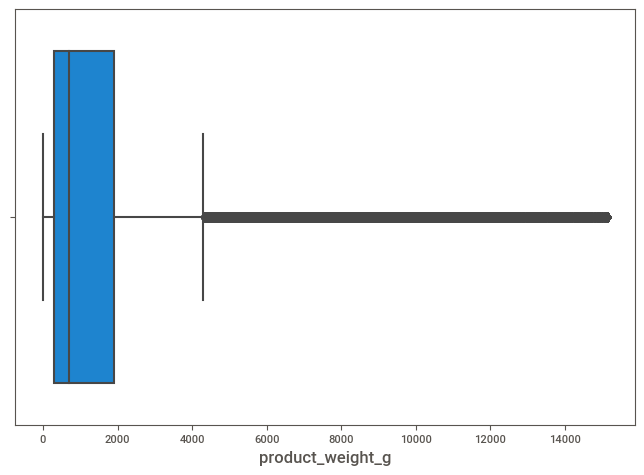

In [2353]:
sns.boxplot(x=dtProducts["product_weight_g"])

<AxesSubplot:xlabel='product_weight_g', ylabel='Count'>

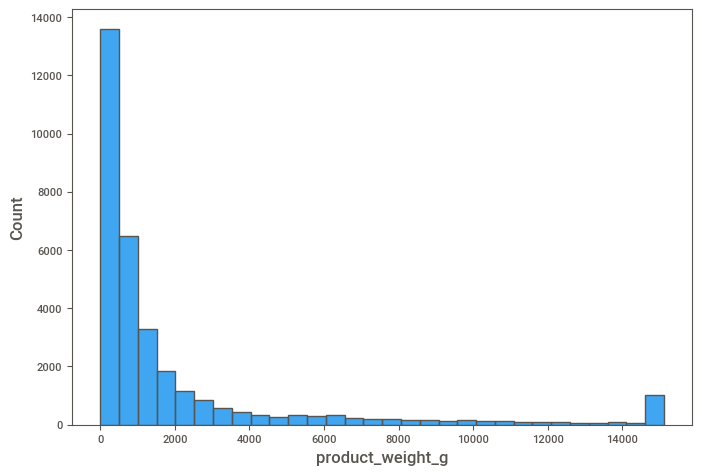

In [2354]:
sns.histplot(data=dtProducts["product_weight_g"], bins=30)

#### Análise de consistência na coluna de comprimento

<AxesSubplot:xlabel='product_length_cm'>

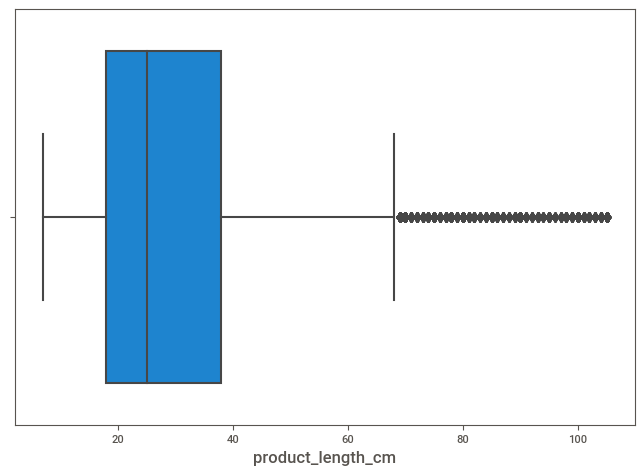

In [2355]:
sns.boxplot(x=dtProducts["product_length_cm"])

In [2356]:
dtProducts["product_length_cm"].mean()

30.81507784758263

In [2357]:
dtProducts["product_length_cm"] = EliminarOutliers(dtProducts["product_length_cm"])

<AxesSubplot:xlabel='product_length_cm'>

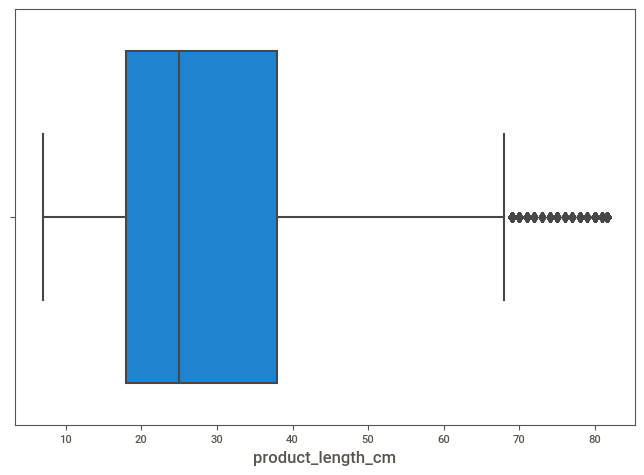

In [2358]:
sns.boxplot(x=dtProducts["product_length_cm"])

<AxesSubplot:xlabel='product_length_cm', ylabel='Count'>

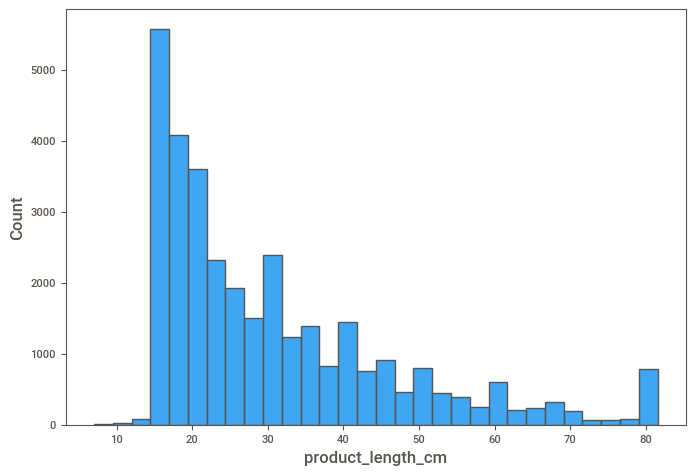

In [2359]:
sns.histplot(data=dtProducts["product_length_cm"], bins=30)

#### Análise de consistência na coluna de altura

<AxesSubplot:xlabel='product_height_cm'>

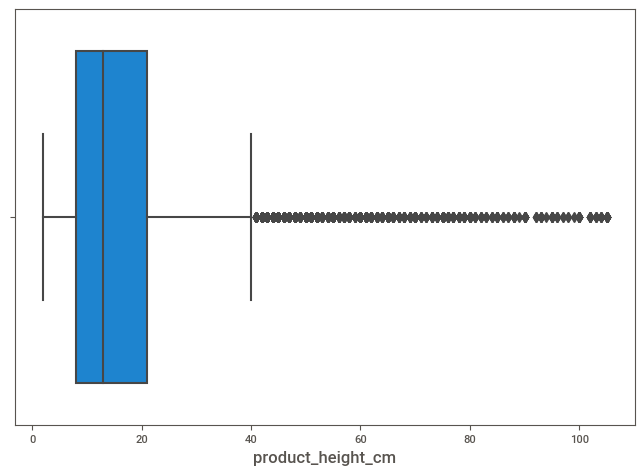

In [2360]:
sns.boxplot(x=dtProducts["product_height_cm"])

In [2361]:
dtProducts["product_height_cm"].mean()

16.937661234028347

In [2362]:
dtProducts["product_height_cm"] = EliminarOutliers(dtProducts["product_height_cm"])

<AxesSubplot:xlabel='product_height_cm'>

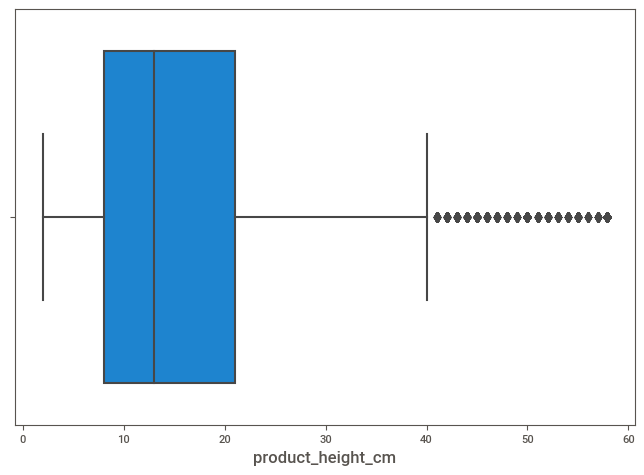

In [2363]:
sns.boxplot(x=dtProducts["product_height_cm"])

<AxesSubplot:xlabel='product_height_cm', ylabel='Count'>

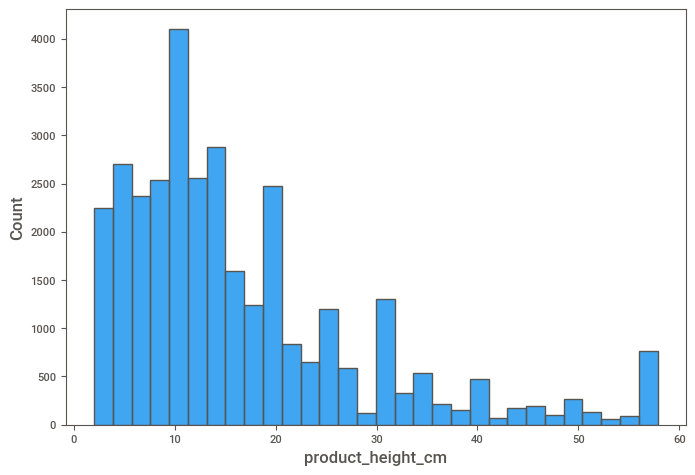

In [2364]:
sns.histplot(data=dtProducts["product_height_cm"], bins=30)

#### Análise de consistência na coluna de largura

<AxesSubplot:xlabel='product_width_cm'>

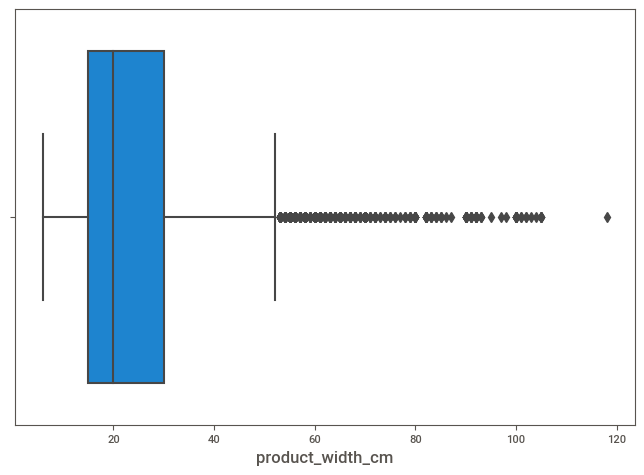

In [2365]:
sns.boxplot(x=dtProducts["product_width_cm"])

In [2366]:
dtProducts["product_width_cm"].mean()

23.196728277034204

In [2367]:
dtProducts["product_width_cm"] = EliminarOutliers(dtProducts["product_width_cm"])

<AxesSubplot:xlabel='product_width_cm'>

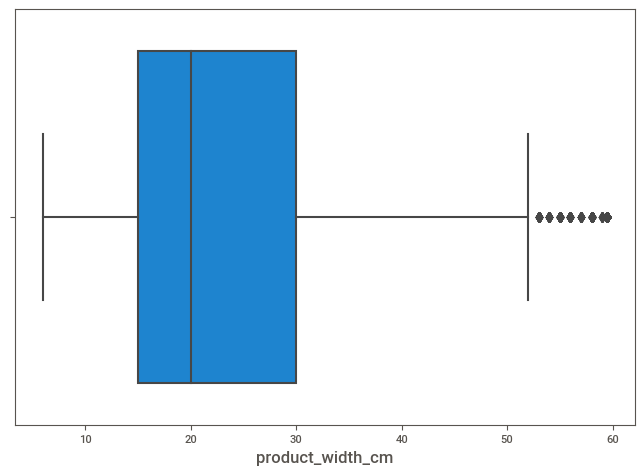

In [2368]:
sns.boxplot(x=dtProducts["product_width_cm"])

<AxesSubplot:xlabel='product_width_cm', ylabel='Count'>

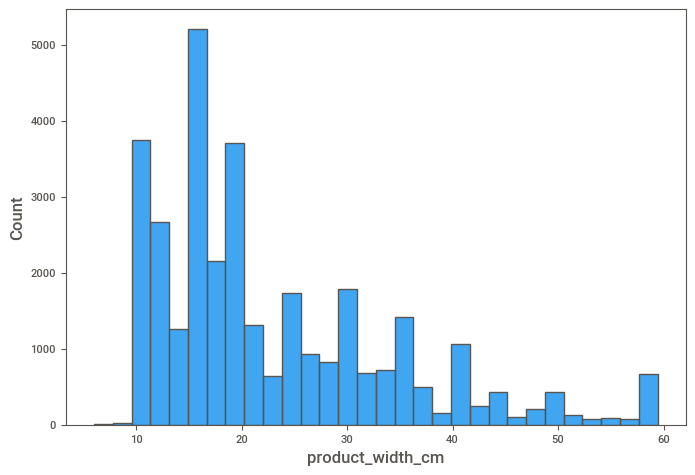

In [2369]:
sns.histplot(data=dtProducts["product_width_cm"], bins=30)

## Preparação

### Products

In [2370]:
dfProducts = dtProducts
dfProducts

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,700.0,31.0,13.0,20.0


#### Tamanho dos produtos

In [2371]:
dfProducts['Volume'] = dfProducts['product_length_cm']*dfProducts['product_height_cm']*dfProducts['product_width_cm']
dfProducts['Volume']

0         2240.0
1        10800.0
2         2430.0
3         2704.0
4         4420.0
          ...   
32946    64000.0
32947     4864.0
32948     5103.0
32949     8060.0
32950      168.0
Name: Volume, Length: 32951, dtype: float64

<AxesSubplot:xlabel='Volume', ylabel='Count'>

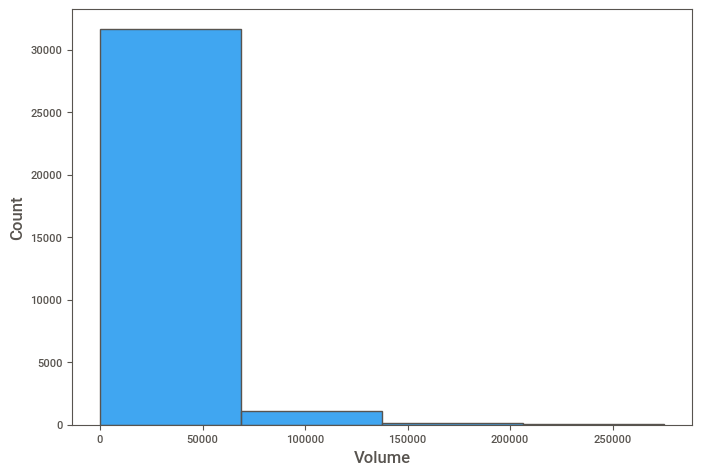

In [2372]:
sns.histplot(data=dfProducts["Volume"], bins=4)

<AxesSubplot:xlabel='Volume'>

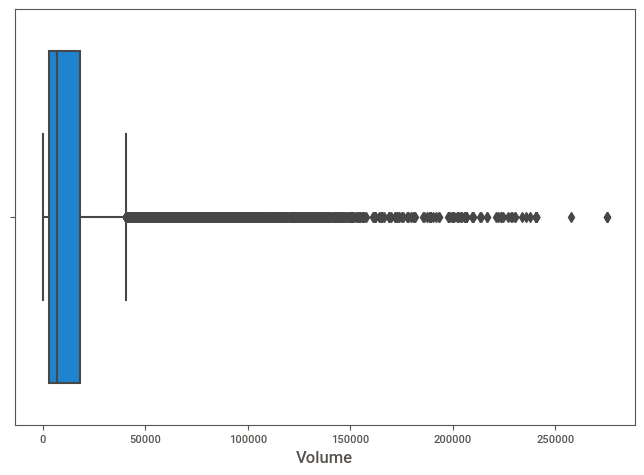

In [2373]:
sns.boxplot(x=dfProducts["Volume"])

In [2374]:
dfProducts["iSize"] = (dfProducts["Volume"] ** (1/3))

<AxesSubplot:xlabel='iSize'>

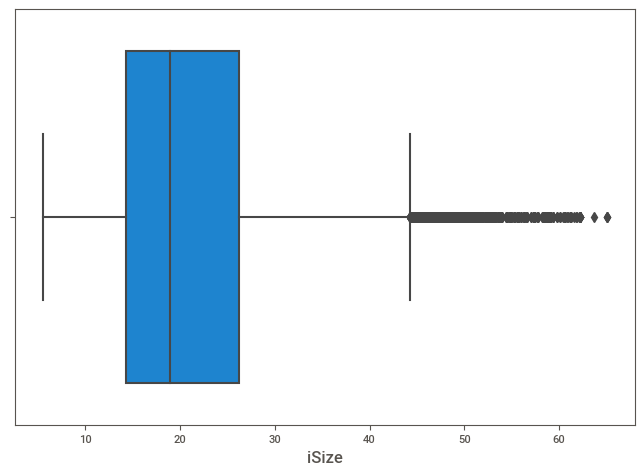

In [2375]:
sns.boxplot(x=dfProducts["iSize"])

In [2376]:
dfProducts["Size"] = dfProducts["iSize"].apply(lambda x: "small" if x<= 20 else "medium" if x<=40 else "big")
dfProducts["Size"]

0         small
1        medium
2         small
3         small
4         small
          ...  
32946    medium
32947     small
32948     small
32949    medium
32950     small
Name: Size, Length: 32951, dtype: object

In [2377]:
dfProducts = pd.get_dummies(dfProducts, columns= ['Size'])
dfProducts = dfProducts.drop(columns=['product_length_cm', 'product_height_cm', 'product_width_cm', 'Volume', 'iSize'])
dfProducts

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_weight_g,Size_big,Size_medium,Size_small
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,225.0,0,0,1
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1000.0,0,1,0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,154.0,0,0,1
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,371.0,0,0,1
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,625.0,0,0,1
...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,12300.0,0,1,0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1700.0,0,0,1
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1400.0,0,0,1
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,700.0,0,1,0


In [2378]:
SizeColumns = [col for col in dfProducts if col.startswith('Size')]

#### Categorias

In [2379]:
dfProducts = pd.get_dummies(dfProducts, columns= ['product_category_name'])
dfProducts

,product_id,product_name_lenght,product_description_lenght,product_weight_g,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,225.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,154.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,371.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,625.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,45.0,67.0,12300.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32947,bf4538d88321d0fd4412a93c974510e6,41.0,971.0,1700.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,50.0,799.0,1400.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32949,83808703fc0706a22e264b9d75f04a2e,60.0,156.0,700.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2380]:
CategoryColumns = [col for col in dfProducts if col.startswith('product_category_name')]

### Order Items

In [2381]:
dfOrderItems = dtOrderItems
dfOrderItems

,order_id,product_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90
...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99
112646,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00
112647,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90
112648,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99


In [2382]:
dfOrderItems = dfOrderItems.merge(dfProducts, on='product_id', how='left')
dfOrderItems

,order_id,product_id,price,product_name_lenght,product_description_lenght,product_weight_g,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,58.0,598.0,650.000000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,56.0,239.0,15122.588681,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,59.0,695.0,3050.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,42.0,480.0,200.000000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,59.0,409.0,3750.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99,43.0,1002.0,10150.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
102421,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00,31.0,232.0,8950.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
102422,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90,43.0,869.0,967.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
102423,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99,56.0,1306.0,100.000000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Agrupando por ordem

In [2383]:
OtherColumnsOrderItems = dfOrderItems.columns
OtherColumnsOrderItems = OtherColumnsOrderItems.drop(SizeColumns)
OtherColumnsOrderItems = OtherColumnsOrderItems.drop(CategoryColumns)
OtherColumnsOrderItems

Index(['order_id', 'product_id', 'price', 'product_name_lenght',
       'product_description_lenght', 'product_weight_g'],
      dtype='object')

In [2384]:
dfOrderItemsPart1 = dfOrderItems.drop(columns=SizeColumns).drop(columns=CategoryColumns)
dfOrderItemsPart1

,order_id,product_id,price,product_name_lenght,product_description_lenght,product_weight_g
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,58.0,598.0,650.000000
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,56.0,239.0,15122.588681
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,59.0,695.0,3050.000000
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,42.0,480.0,200.000000
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,59.0,409.0,3750.000000
...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99,43.0,1002.0,10150.000000
102421,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00,31.0,232.0,8950.000000
102422,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90,43.0,869.0,967.000000
102423,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99,56.0,1306.0,100.000000


In [2385]:
dfOrderItemsPart1 = dfOrderItemsPart1.groupby(by='order_id').agg('mean')
dfOrderItemsPart1

,price,product_name_lenght,product_description_lenght,product_weight_g
order_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,58.90,58.0,598.0,650.000000
00018f77f2f0320c557190d7a144bdd3,239.90,56.0,239.0,15122.588681
000229ec398224ef6ca0657da4fc703e,199.00,59.0,695.0,3050.000000
00024acbcdf0a6daa1e931b038114c75,12.99,42.0,480.0,200.000000
00042b26cf59d7ce69dfabb4e55b4fd9,199.90,59.0,409.0,3750.000000
...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,299.99,43.0,1002.0,10150.000000
fffcd46ef2263f404302a634eb57f7eb,350.00,31.0,232.0,8950.000000
fffce4705a9662cd70adb13d4a31832d,99.90,43.0,869.0,967.000000


In [2386]:
dfOrderItemsPart2 = dfOrderItems.drop(columns=(OtherColumnsOrderItems.drop('order_id')))
dfOrderItemsPart2

,order_id,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,00010242fe8c5a6d1ba2dd792cb16214,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00018f77f2f0320c557190d7a144bdd3,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00024acbcdf0a6daa1e931b038114c75,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
102421,fffcd46ef2263f404302a634eb57f7eb,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102422,fffce4705a9662cd70adb13d4a31832d,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102423,fffe18544ffabc95dfada21779c9644f,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2387]:
dfOrderItemsPart2 = dfOrderItemsPart2.groupby(by='order_id').agg('sum')
dfOrderItemsPart2

,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,product_category_name_artigos_de_natal,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00018f77f2f0320c557190d7a144bdd3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
000229ec398224ef6ca0657da4fc703e,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00024acbcdf0a6daa1e931b038114c75,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00042b26cf59d7ce69dfabb4e55b4fd9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
fffcd46ef2263f404302a634eb57f7eb,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fffce4705a9662cd70adb13d4a31832d,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Dataframe com dados de produtos e itens de ordens

In [2388]:
df = dfOrderItemsPart1.merge(dfOrderItemsPart2, on='order_id', how='left')
df.reset_index(level=0, inplace=True)
df

,order_id,price,product_name_lenght,product_description_lenght,product_weight_g,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,58.0,598.0,650.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00018f77f2f0320c557190d7a144bdd3,239.90,56.0,239.0,15122.588681,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,000229ec398224ef6ca0657da4fc703e,199.00,59.0,695.0,3050.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00024acbcdf0a6daa1e931b038114c75,12.99,42.0,480.0,200.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,59.0,409.0,3750.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.0,1002.0,10150.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,31.0,232.0,8950.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98663,fffce4705a9662cd70adb13d4a31832d,99.90,43.0,869.0,967.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98664,fffe18544ffabc95dfada21779c9644f,55.99,56.0,1306.0,100.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Order Reviews

In [2389]:
dfReviews = dtOrderReviews
dfReviews

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4


In [2390]:
dfReviews = dfReviews.drop(columns=['review_id'])
dfReviews

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,5
99220,22ec9f0669f784db00fa86d035cf8602,5
99221,55d4004744368f5571d1f590031933e4,5
99222,7725825d039fc1f0ceb7635e3f7d9206,4


#### Agrupando por ordem

In [2391]:
dfReviews = dfReviews.groupby(by='order_id').agg(['count', np.nanmean])
dfReviews.columns = ['_'.join(col).strip() if col[1] != "" else col[0] for col in dfReviews.columns.values]
dfReviews = dfReviews.reset_index()
dfReviews

,order_id,review_score_count,review_score_nanmean
0,00010242fe8c5a6d1ba2dd792cb16214,1,5.0
1,00018f77f2f0320c557190d7a144bdd3,1,4.0
2,000229ec398224ef6ca0657da4fc703e,1,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,5.0
...,...,...,...
98668,fffc94f6ce00a00581880bf54a75a037,1,5.0
98669,fffcd46ef2263f404302a634eb57f7eb,1,5.0
98670,fffce4705a9662cd70adb13d4a31832d,1,5.0
98671,fffe18544ffabc95dfada21779c9644f,1,5.0


### Orders

In [2392]:
dfOrders = dtOrders
dfOrders

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered


#### Status

In [2393]:
StatusOptions = dfOrders['order_status'].unique()
StatusOptions

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [2394]:
StatusNotSucceed = ['canceled', 'unavailable']
StatusNotSucceed

['canceled', 'unavailable']

In [2395]:
dfOrders['Succeed']=np.where((dfOrders['order_status'] == ('canceled' or 'unavailable')), 0, 1)
dfOrders = dfOrders.drop(columns='order_status')
dfOrders

,order_id,customer_id,Succeed
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,1
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,1
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,1
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,1
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,1
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,1


In [2396]:
dfOrders['Succeed'].value_counts()

1    98816
0      625
Name: Succeed, dtype: int64

#### Dataframe com dados de ordens, itens e produtos

In [2397]:
df = df.merge(dfOrders, on='order_id', how='left')
df = df.merge(dfReviews, on='order_id', how='left')
df

,order_id,price,product_name_lenght,product_description_lenght,product_weight_g,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,...,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas,customer_id,Succeed,review_score_count,review_score_nanmean
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,58.0,598.0,650.000000,0,0,1,0,0,...,0,0,0,0,0,0,3ce436f183e68e07877b285a838db11a,1,1.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,239.90,56.0,239.0,15122.588681,0,1,0,0,0,...,0,0,0,0,0,0,f6dd3ec061db4e3987629fe6b26e5cce,1,1.0,4.0
2,000229ec398224ef6ca0657da4fc703e,199.00,59.0,695.0,3050.000000,0,1,0,0,0,...,0,0,0,0,0,0,6489ae5e4333f3693df5ad4372dab6d3,1,1.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,12.99,42.0,480.0,200.000000,0,0,1,0,0,...,0,0,0,0,0,0,d4eb9395c8c0431ee92fce09860c5a06,1,1.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,59.0,409.0,3750.000000,0,1,0,0,0,...,0,0,0,0,0,0,58dbd0b2d70206bf40e62cd34e84d795,1,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.0,1002.0,10150.000000,0,1,0,0,0,...,0,0,0,0,0,1,b51593916b4b8e0d6f66f2ae24f2673d,1,1.0,5.0
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,31.0,232.0,8950.000000,0,1,0,0,0,...,0,0,0,0,0,0,84c5d4fbaf120aae381fad077416eaa0,1,1.0,5.0
98663,fffce4705a9662cd70adb13d4a31832d,99.90,43.0,869.0,967.000000,0,1,0,0,0,...,0,0,0,0,0,0,29309aa813182aaddc9b259e31b870e6,1,1.0,5.0
98664,fffe18544ffabc95dfada21779c9644f,55.99,56.0,1306.0,100.000000,0,0,1,0,0,...,0,0,0,0,0,0,b5e6afd5a41800fdf401e0272ca74655,1,1.0,5.0


#### Agrupando por cliente

In [2398]:
ColumnsToSum = SizeColumns + CategoryColumns
ColumnsToSum

ColumnsToMean = df.columns
ColumnsToMean = ColumnsToMean.drop(ColumnsToSum)
ColumnsToMean

Index(['order_id', 'price', 'product_name_lenght',
       'product_description_lenght', 'product_weight_g', 'customer_id',
       'Succeed', 'review_score_count', 'review_score_nanmean'],
      dtype='object')

In [2399]:
dfPart1 = df.drop(columns=ColumnsToSum)
dfPart1

,order_id,price,product_name_lenght,product_description_lenght,product_weight_g,customer_id,Succeed,review_score_count,review_score_nanmean
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,58.0,598.0,650.000000,3ce436f183e68e07877b285a838db11a,1,1.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,239.90,56.0,239.0,15122.588681,f6dd3ec061db4e3987629fe6b26e5cce,1,1.0,4.0
2,000229ec398224ef6ca0657da4fc703e,199.00,59.0,695.0,3050.000000,6489ae5e4333f3693df5ad4372dab6d3,1,1.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,12.99,42.0,480.0,200.000000,d4eb9395c8c0431ee92fce09860c5a06,1,1.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,59.0,409.0,3750.000000,58dbd0b2d70206bf40e62cd34e84d795,1,1.0,5.0
...,...,...,...,...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.0,1002.0,10150.000000,b51593916b4b8e0d6f66f2ae24f2673d,1,1.0,5.0
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,31.0,232.0,8950.000000,84c5d4fbaf120aae381fad077416eaa0,1,1.0,5.0
98663,fffce4705a9662cd70adb13d4a31832d,99.90,43.0,869.0,967.000000,29309aa813182aaddc9b259e31b870e6,1,1.0,5.0
98664,fffe18544ffabc95dfada21779c9644f,55.99,56.0,1306.0,100.000000,b5e6afd5a41800fdf401e0272ca74655,1,1.0,5.0


In [2400]:
dfPart1 = dfPart1.groupby(by=['customer_id']).agg('mean')
dfPart1 = dfPart1.reset_index()
dfPart1

,customer_id,price,product_name_lenght,product_description_lenght,product_weight_g,Succeed,review_score_count,review_score_nanmean
0,00012a2ce6f8dcda20d059ce98491703,89.80,55.0,889.0,4267.0,1,1.0,1.0
1,000161a058600d5901f007fab4c27140,54.90,57.0,2563.0,150.0,1,1.0,4.0
2,0001fd6190edaaf884bcaf3d49edf079,179.99,45.0,1042.0,750.0,1,1.0,5.0
3,0002414f95344307404f0ace7a26f1d5,149.90,38.0,840.0,1600.0,1,1.0,5.0
4,000379cdec625522490c315e70c7a9fb,93.00,57.0,364.0,800.0,1,1.0,4.0
...,...,...,...,...,...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,78.00,39.0,2244.0,1250.0,1,1.0,5.0
98662,fffecc9f79fd8c764f843e9951b11341,54.90,48.0,641.0,2050.0,1,1.0,3.0
98663,fffeda5b6d849fbd39689bb92087f431,47.90,59.0,458.0,350.0,1,1.0,4.0
98664,ffff42319e9b2d713724ae527742af25,199.90,60.0,268.0,2700.0,1,1.0,5.0


In [2401]:
dfPart2 = df.drop(columns=ColumnsToMean.drop('customer_id'))
dfPart2

,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,product_category_name_artigos_de_natal,...,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas,customer_id
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3ce436f183e68e07877b285a838db11a
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,f6dd3ec061db4e3987629fe6b26e5cce
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6489ae5e4333f3693df5ad4372dab6d3
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,d4eb9395c8c0431ee92fce09860c5a06
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58dbd0b2d70206bf40e62cd34e84d795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98661,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,b51593916b4b8e0d6f66f2ae24f2673d
98662,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,84c5d4fbaf120aae381fad077416eaa0
98663,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,29309aa813182aaddc9b259e31b870e6
98664,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b5e6afd5a41800fdf401e0272ca74655


In [2402]:
dfPart2 = dfPart2.groupby(by=['customer_id']).agg('sum')
dfPart2 = dfPart2.reset_index()
dfPart2

,customer_id,Size_big,Size_medium,Size_small,product_category_name_agro_industria_e_comercio,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,00012a2ce6f8dcda20d059ce98491703,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000161a058600d5901f007fab4c27140,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0001fd6190edaaf884bcaf3d49edf079,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0002414f95344307404f0ace7a26f1d5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,000379cdec625522490c315e70c7a9fb,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98662,fffecc9f79fd8c764f843e9951b11341,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98663,fffeda5b6d849fbd39689bb92087f431,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
98664,ffff42319e9b2d713724ae527742af25,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2403]:
df = dfPart1.merge(dfPart2, on='customer_id', how='left')
df

,customer_id,price,product_name_lenght,product_description_lenght,product_weight_g,Succeed,review_score_count,review_score_nanmean,Size_big,Size_medium,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,00012a2ce6f8dcda20d059ce98491703,89.80,55.0,889.0,4267.0,1,1.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,000161a058600d5901f007fab4c27140,54.90,57.0,2563.0,150.0,1,1.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0001fd6190edaaf884bcaf3d49edf079,179.99,45.0,1042.0,750.0,1,1.0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0002414f95344307404f0ace7a26f1d5,149.90,38.0,840.0,1600.0,1,1.0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,000379cdec625522490c315e70c7a9fb,93.00,57.0,364.0,800.0,1,1.0,4.0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,78.00,39.0,2244.0,1250.0,1,1.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
98662,fffecc9f79fd8c764f843e9951b11341,54.90,48.0,641.0,2050.0,1,1.0,3.0,0,1,...,0,0,0,0,0,0,0,0,0,0
98663,fffeda5b6d849fbd39689bb92087f431,47.90,59.0,458.0,350.0,1,1.0,4.0,0,1,...,0,0,0,0,0,0,0,1,0,0
98664,ffff42319e9b2d713724ae527742af25,199.90,60.0,268.0,2700.0,1,1.0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Dataframe preparado

In [2405]:
df

,customer_id,price,product_name_lenght,product_description_lenght,product_weight_g,Succeed,review_score_count,review_score_nanmean,Size_big,Size_medium,...,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_portateis_cozinha_e_preparadores_de_alimentos,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
0,00012a2ce6f8dcda20d059ce98491703,89.80,55.0,889.0,4267.0,1,1.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,000161a058600d5901f007fab4c27140,54.90,57.0,2563.0,150.0,1,1.0,4.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0001fd6190edaaf884bcaf3d49edf079,179.99,45.0,1042.0,750.0,1,1.0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0002414f95344307404f0ace7a26f1d5,149.90,38.0,840.0,1600.0,1,1.0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,000379cdec625522490c315e70c7a9fb,93.00,57.0,364.0,800.0,1,1.0,4.0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,78.00,39.0,2244.0,1250.0,1,1.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
98662,fffecc9f79fd8c764f843e9951b11341,54.90,48.0,641.0,2050.0,1,1.0,3.0,0,1,...,0,0,0,0,0,0,0,0,0,0
98663,fffeda5b6d849fbd39689bb92087f431,47.90,59.0,458.0,350.0,1,1.0,4.0,0,1,...,0,0,0,0,0,0,0,1,0,0
98664,ffff42319e9b2d713724ae527742af25,199.90,60.0,268.0,2700.0,1,1.0,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0
